<a href="https://colab.research.google.com/github/phenix-project/Colabs/blob/main/GNN_examples/GNN_Demo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks
#### Graph neural networks (GNNs) are an architecture which is particularly well suited for doing machine learning tasks on molecules. Some recent examples of papers applying GNNs for molecular structure generation and molecular property regression:

 - Baek, Minkyung, et al. "Accurate prediction of protein structures and interactions using a 3-track network." bioRxiv (2021).
 - Townshend, Raphael JL, et al. "Geometric deep learning of RNA structure." Science 373.6558 (2021): 1047-1051.

 - Ganea, Octavian-Eugen, et al. "GeoMol: Torsional Geometric Generation of Molecular 3D Conformer Ensembles." arXiv preprint arXiv:2106.07802 (2021).

- Wang, Yuanqing, Josh Fass, and John D. Chodera. "End-to-End Differentiable Molecular Mechanics Force Field Construction." arXiv preprint arXiv:2010.01196 (2020).


#### The basic GNN architecture is shown below. The first phase, message passing builds up an expressive and task specific hidden representation for each atom node. The second phase, readout, provides a mechanism for aggregating atom representations for tasks at the fragment or molecule level.


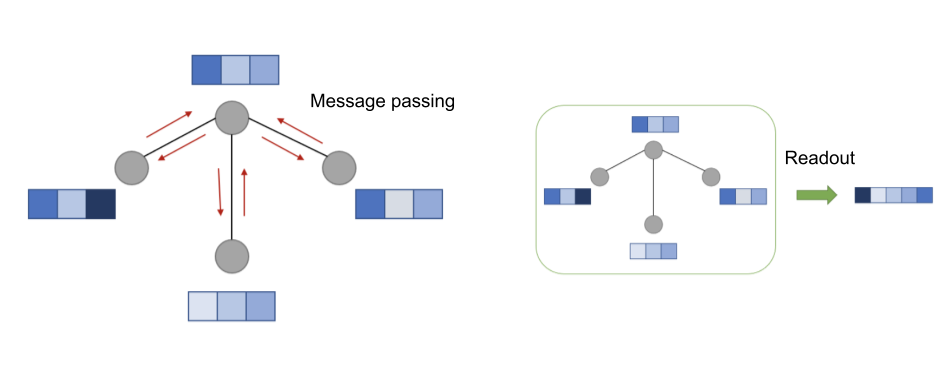

- Image adapted from: Li, Mufei, et al. "Dgl-lifesci: An open-source toolkit for deep learning on graphs in life science." ACS omega 6.41 (2021): 27233-27238.

# Installation
#### The installation is split into separate cells because the runtime must be restarted multiple times for proper installation. Press each play button in order.

In [ ]:
#@title 1. Install Anaconda package manager
#@markdown You will get warnings about the session crashing, this is expected, it occurs when the runtime restarts.
!pip install -q condacolab
import condacolab
condacolab.install() # this triggers a restart

In [ ]:
#@title 2. Install dependencies using Anaconda
#@markdown This can take a while
%%capture
! mamba install --yes --strict-channel-priority -c pytorch -c dglteam -c conda-forge pytorch torchvision torchaudio cudatoolkit dgl-cuda10.1 cctbx-base rdkit py3dmol

! apt install -y subversion
# provide location of libtbx environment
#%shell ln -s /usr/local/share/cctbx /usr/share/cctbx

# replace system libstdc++ with conda version
# restart runtime after running
# to keep changes persistent, modify the filesystem, not environment variables
#%shell sudo cp /usr/local/lib/libstdc++.so.6.0.29 /usr/lib/x86_64-linux-gnu/libstdc++.so.6 

exit() # restart runtime

In [ ]:
#@title 3. Set up the CCTBX library
%%capture
%%bash

# commented out because it takes a very long time. Geometry restraints will be unavailable

# # get chemical data
# rm -rf cd  /usr/local/lib/python3.7/site-packages/chem_data
# cd  /usr/local/lib/python3.7/site-packages
# mkdir chem_data
# cd chem_data

# svn --quiet --non-interactive --trust-server-cert co https://github.com/phenix-project/geostd.git/trunk geostd
# svn --quiet --non-interactive --trust-server-cert co https://github.com/rlabduke/mon_lib.git/trunk mon_lib
# svn --quiet --non-interactive --trust-server-cert export https://github.com/rlabduke/reference_data.git/trunk/Top8000/Top8000_rotamer_pct_contour_grids rotarama_data
# svn --quiet --non-interactive --trust-server-cert --force export https://github.com/rlabduke/reference_data.git/trunk/Top8000/Top8000_ramachandran_pct_contour_grids rotarama_data
# svn --quiet --non-interactive --trust-server-cert co https://github.com/rlabduke/reference_data.git/trunk/Top8000/Top8000_cablam_pct_contour_grids cablam_data
# svn --quiet --non-interactive --trust-server-cert co https://github.com/rlabduke/reference_data.git/trunk/Top8000/rama_z rama_z

# # update rotamer and cablam cache
# /usr/local/bin/mmtbx.rebuild_rotarama_cache
# /usr/local/bin/mmtbx.rebuild_cablam_cache


# # get probe
# rm -rf cctbx-notebooks
# git clone https://github.com/cschlick/cctbx-notebooks.git
# mkdir -p /usr/local/share/cctbx/probe/exe
# cp cctbx-notebooks/probe /usr/local/share/cctbx/probe/exe
# chmod +x /usr/local/share/cctbx/probe/exe/probe
# mkdir -p /usr/lib/python3.7/site-packages/probe
# mkdir -p /usr/lib/python3.7/site-packages/reduce




In [ ]:
#@title ... and also set CCTBX environment variables
#  Manually update sys.path
%%capture
%env PYTHONPATH="$/env/python:/usr/local/lib:/usr/local/lib/python3.7/lib-dynload:/usr/local/lib/python3.7/site-packages"

# add conda paths to sys.path
import sys, os
sys.path.extend(['/usr/local/lib', '/usr/local/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/site-packages',"/content/cctbx_py3dmol"])
os.environ["MMTBX_CCP4_MONOMER_LIB"]="/usr/local/lib/python3.7/site-packages/chem_data/geostd"
os.environ["LIBTBX_BUILD"]= "/usr/local/share/cctbx"

import cctbx
import libtbx
libtbx.env.add_repository("/usr/local/lib/python3.7/site-packages/")

In [ ]:
#@title 4. Download molecular structures
# this uses the rcsb bash script. 

%%capture
!wget https://www.rcsb.org/scripts/batch_download.sh

max_structures = 20 # a cap on the number of pdb codes to download (for debugging)

# pdb code filter criteria (Jan 2022):
# 1. Resolution better than 1.5 A
# 2. Contains protein components
# 3. 500< n_atoms < 20000 
pdb_codes = """5WLF,1TH6,4Y9I,1QK8,1DWT,2IZX,4PQ6,1BGF,6CUK,5NBJ,3NJU,7NHU,1DJT,6AJV,3WJD,1KJL,5ZX8,4KL9,3DQ7,5NMJ,3TUA,5RPI,2VHK,1YII,7LIN,4MUM,5PPE,5QPP,6Y82,2HYK,3U25,5B5H,4DXZ,5MHQ,3RYZ,1SQ2,6X1N,3WR0,5XW2,4NNO,6DP1,5RCC,4B9A,2VFD,5AOS,4AF8,4MWP,6XNB,1HZT,4RPQ,5RWO,7D5B,4E97,3NYQ,5FUI,3A2O,6FM6,3V4K,2PIE,6QNV,6R01,5LJC,2V52,6FR5,3VKT,3UQI,2G8C,6LUY,5M9W,4LXT,6GJL,4HXQ,4LVU,3CB9,2QD7,6N4Z,5PJO,7S7Y,4JU9,5RWS,5N1S,2VI4,5Q2J,6X8A,4HS5,7NFW,1OTE,5ILU,6L5H,2ZQD,4X5P,6AID,3P6D,3EG3,4IEU,6UWW,3WVS,2WHL,6SG0,5P7M,2I3F,3D9X,7EE3,6KBY,5PJU,1SVN,1ODM,5DK1,4N9S,1SMM,2Z6W,4H0D,2WLV,4X9R,2D1S,3EYI,5CLZ,5OP9,5IXH,6AF9,5IDV,3DK8,5F5N,3W19,5Q3Y,7NES,6LDL,4XZH,1G3P,5JSW,2VR8,6EKZ,3QU3,5P6D,6XWE,6LUT,1NZ0,7AM9,6GNA,3I4O,7ABT,5MPN,1EU5,5AWO,5MAE,2VK5,3TV3,3CNJ,2FG1,6DMH,5IPH,6G1G,4DQ7,5KTU,3OIW,6IQF,3UY7,3DVS,4N9P,3TJW,4L1I,6D3B,4HT2,7JO3,7B02,5K1P,1X99,5MJR,3AOF,7O6O,5S7K,6GGD,6Q4D,5Z95,5C98,5S2M,6RI4,3RY8,6RIL,5MKA,3LHC,4NUE,4ML5,4E46,1K5N,7RNS,6SJ2,3L84,3MFJ,5ZIW,5P33,6HOG,2GU9,6DL2,1VL9,3V1A,1O8X,6SV8,3CZN,6ZPC,1ZJY,6P28,2DRK,3PAV,6ZAN,5OFJ,3PRS,2G3R,3ELN,7NFB,4MAM,3C1P,6ONG,1NKO,5RSH,2QGB,5B4H,4G9G,5PNM,5BZK,4Z50,5ZGX,6T27,6UR3,6Q2Y,1FK5,6TIB,6YHA,1QX1,5RUH,5C4D,5TA0,5LL5,3NQ7,4DJP,4Q8V,3SXE,4BT5,2VH3,4OPZ,6XZL,2HLQ,6WOC,2I5V,6XRK,4EVQ,5ZXE,5YUI,5CN3,1F24,3NYR,1VM9,7L9S,3DVQ,6V7G,7N7H,6QO8,1UGU,4U9H,4XYY,5PV3,6P2N,6GS0,6F70,3P6J,2XG3,1JXW,5PMJ,4YEO,6FIY,5S30,5P37,5RDH,5RU9,5P14,5Q6G,5BRY,2QVB,1GA1,4YUJ,4CGS,5YOK,7BHM,7O6A,3E5O,5PWS,2DF6,2IMQ,6D9M,5W46,3PB4,3CXZ,2QT4,6ZMV,6S1H,5PKQ,3PXL,6M65,5KU3,6SUX,7BCX,3X33,5ZRK,3A7I,3N4J,1WCK,6G8Y,4GZC,5RUW,6Z62,5RF6,6ER3,3ZIJ,2ZK9,5IBQ,6BPF,5K26,4I3G,5KZ6,6S25,3LB2,2E5F,3MO7,1C1D,5PHB,5NLO,1OOF,4RDC,1PQH,5PII,6OGC,4UHM,5HL3,3ISX,5IVT,3RY1,2C60,1WMD,2UV4,5D5Y,1IWU,5QR5,5TOY,5PKY,5ZT3,5V8S,4NKC,6F6Y,3W4O,3E0X,4DP8,4YTW,3ECZ,4ZEF,5HEE,2FT7,3P64,6YNN,6TCR,5TON,6BG3,5AGD,4YPC,5R2T,4UQC,5OTQ,7DJR,3NFK,5QUB,1NUW,1D7E,5RP0,4Q6D,3A39,7DOH,6AXQ,4KXV,6Y8H,5MAO,6D30,3BZZ,6YZQ,7DEQ,3AUH,4YSI,5RWE,6RZ0,1GVV,5S4I,6EQ4,4OG6,6R2Z,5PNJ,7S0P,7BQI,6XMA,5MB6,1M0M,2JEP,3X2L,6E9A,2WD2,3UGL,5MFI,6QOB,5LQ6,6D7A,5QPT,5J4K,2QSK,5RT9,6QX0,5Q9P,3UI6,5R1W,7KIH,1TQW,3GQ1,2Y62,3S2J,4YEC,7ESM,2PND,5DGD,6JUC,4BAT,2ILI,3FEG,3S54,3A8G,1E6Q,3KUN,2GUD,5WPS,5IGI,256B,2HPH,3DA8,2BJD,4CV7,3LZQ,5PLH,6JB9,4HSW,7CXB,3M6B,5FQA,3P95,5B4J,1UBJ,1MF7,5P5J,1NXB,5O95,5K3D,5RWM,7A2B,4EOD,1KB0,5S2T,4ZKR,3F1N,3V43,7JOB,4Q07,6RHI,4MC9,4YLQ,4E9S,5XBI,6FF1,5IBP,1CUS,6H5D,1C5R,4AQO,3G8H,5MT2,6RXA,1JCD,6QRN,5PM4,7OKE,6T0K,5QIA,6S43,1KUG,6W1H,7K9B,3CBW,5R39,6LZB,1MJ5,5F60,1LS9,6N9M,3FWK,2VNZ,4HE5,4ATE,5S92,4NOV,6VIG,4L9D,5PJ7,6GJJ,5I1P,3WN8,6YQ0,6GI7,5ETM,6RY3,6ZYP,4PM9,3W4P,6V7P,1EAX,7SN1,6EDV,5A0N,4ZG8,6T6X,6JU7,3GZQ,5JQF,6Y01,5Q4P,2B06,1OXD,4GQQ,7P6W,2O5G,6SDP,2JB2,3S2R,1VD6,7EK9,1TJK,6YX7,4RY1,1K3X,2ZSZ,4TJZ,2AS2,6YH7,3CT5,6AIR,3SHX,3EW0,3FCI,5RVK,6YVM,2HQZ,5PNU,5HJG,6E2B,5XQV,6ZRN,7EZI,2D4J,3D3B,3R9F,3A0M,5NR8,5YOG,5RBV,5VW2,5E23,3OZS,6XXR,2P74,4NUC,1KV0,6OFL,6AGN,7EAM,3T6I,5RVG,6I73,5PLP,2IZB,4RMQ,2E7Z,4H8X,5RCG,6EXX,5Q6R,5N5G,6YN3,3MCW,3PWW,2ZD8,6TC2,5RX4,5QPQ,6GAJ,1G61,1R5Y,5TY3,6V1M,6EIO,6YBE,7L9G,5QHV,6A8K,6EKY,5M1P,6NLA,6R3L,6ETT,7C31,6SL9,5S2S,2P1X,5LVS,1J0O,7C6C,3LJM,2XR6,3BOI,5Q3Q,4NMT,3MXS,5LWO,4RAX,2V8B,3I06,2ABA,6GXJ,1L7M,4OU0,4GDA,2DRM,3BUV,5RW8,1MFG,3SBM,3CJW,1IFC,2GLK,4ITB,4DGD,6ZED,1SWU,3PGP,3PFX,6GVD,7O9D,4YBM,5CMB,1QX2,1HQ2,5JFD,6YQG,3BUW,4UP0,4BAZ,3QJA,3NYT,6K4T,5RDO,6FWP,3W29,6UUE,6AYQ,3IIX,7K68,3RZY,3I0J,6BLN,5GHJ,2W4J,5IPC,3ZIY,6Z8H,4WW1,5AZ3,5P6Q,1H2X,1P36,6L61,5E9N,3D95,6LAN,6YO2,6GRE,7NL5,5S93,4QPT,4OUF,4N8Z,2IYS,3HGP,4H9F,1HMT,4B4I,5S3Z,4JG2,6YF2,7CEH,6DCM,5NRA,6GHX,7B8H,4E3L,1R7J,4QR4,5RJV,3H87,2ECU,1SI1,3TA7,6F7W,5MPV,4BOJ,5FO2,3L0K,7LTL,3LL2,5FXN,6FAR,4JM5,5D3U,5KMC,6FM5,5I9Y,4Y4Z,3MDX,2GOM,5RJX,5PH7,4FI8,3RN3,4AU1,5Q5E,6BEV,4WQD,1ONH,1VWG,1RE9,6W70,4WRV,3P60,5FBE,6M83,4RDB,4JOJ,6DDJ,6DS9,1BXQ,2JB4,2BY6,5RE3,1G6C,5RKB,3GHV,4K41,5RU4,1V7S,3S2N,4S29,2BJS,1KG2,4AE7,4S3E,7KI9,5WLV,4ESP,4UDW,3I2Z,4P2K,5RXK,5I88,4LC8,5M9R,6PHI,6QWY,6H17,3QM6,5RPD,5TP0,1SWY,5IKD,1T1E,6QXQ,4WS2,5QB5,2RIL,4J9C,5P4F,6PHM,3VIL,1YM1,4XX9,5P70,5OHH,3PLB,6G0R,5R97,1SKG,5RWB,4CFQ,5NI3,4LA9,3OG2,5P6M,4PVI,4KMG,1VKK,7CCW,6T0P,5P0S,2JJJ,6UIU,5ZKZ,1IC6,5PX4,3LBO,6L0X,2I7D,2JLJ,3AL7,6SPT,6DMJ,6S0C,5QUU,5WK0,6ZWF,5QY9,4DND,1T3R,1CZB,6LUV,4PM1,2JFS,3O8Q,5ZBZ,4EU9,3O5Q,2F9S,4INW,3OM0,4CFR,1EXR,6T2H,4GBU,1AHO,5C0E,4WES,6UWX,3K34,6ZMX,5C4M,5XFC,4H9H,4BK7,7OYW,7KYU,6YIS,4QLP,6YZN,6FWL,3TGB,3T7Q,6SX1,4REK,6Q7C,5RK2,5R24,5HQ1,1RCQ,6N1B,6S42,4JOS,3F00,6LD2,5NM6,5ZWP,3ZRX,5RT5,3FGV,1UBK,3S0K,5T5J,5N31,3GOF,3OE4,6VRR,1G8A,4PWQ,1VYK,4RTX,4XOT,3WUZ,6RO6,3TVN,3QDT,3PKV,6SRY,6ZBK,6F3B,2OYF,7NPC,6TFR,5PN2,5DNU,6BT6,5I06,5RT2,4IZS,6DN7,1NUY,6WBW,4D5I,5LY8,1UQ5,2X5Y,5Z1S,4DE3,2WWE,4KZV,6I3B,5AD1,6KA9,5S34,6JGB,5U0E,7A5Z,1S3C,5D82,1NCW,5R42,2B3P,3IQJ,3PMC,6FK2,7JUB,5PJ8,6HDM,5W55,6FTH,4NMP,5YCE,6NLQ,5Q80,6ZXT,6HB9,6UWA,7BDA,4B4E,6CWK,2V3I,4U2W,5RCZ,6W9L,3AJ8,5RP6,2O0B,2CXV,6KC4,6YCG,5NNG,4CK4,6QJU,6KWD,6H6S,7COF,5P9W,6MKK,7LOA,1V7R,4ONL,6B29,6Y8E,4PN2,5AI3,3BF7,5AVH,1OD1,5P2R,5MON,3NG8,6ZB8,3UCB,5MSZ,5Y9Z,4JM8,6QPR,3FZW,4MYS,5MK9,5F82,7BIF,6AJQ,5RDB,3U97,4WX4,5ROI,4J4Z,3M3A,2CE2,7CL8,5PHF,1ZMI,3JQL,5PXS,5EL9,2ZSP,5UMP,5DSM,5F66,6NPP,6T82,6RTP,6FFW,7DVW,6H29,3VIM,2Q0L,4BT7,6SBE,5EH8,6Y1J,6QTU,1ZCE,5P6P,3O89,2IFQ,7NJB,3PD7,5P7U,5RF8,2WLR,5JUA,6EKG,3CY6,5X40,4H4J,4CNF,3UFF,5P3S,5VGB,2D8D,7D3D,6ZRW,1TC1,5S75,2EUO,4HPJ,5KAR,5LND,2ALL,4YZ0,2V1I,7O0O,5PNP,6RHU,3T0H,4J5R,2YL0,1C2H,6H28,3GMX,6FNH,6GJK,6ZC7,7JNW,4KZ5,3R6D,6FEX,5Q34,3S2L,5NQ0,4IOR,6S7W,7KDB,3OCY,4YU0,7P51,3E6Z,6MZ1,5R41,1XBI,1C2J,4RGY,5L8P,3KUH,6J9O,4BUH,7A3M,6M8Y,4DM7,3QSD,5JAZ,5S3C,3HUK,3WY6,1J2R,6UR1,7A73,4IRL,2QPN,3FS9,5H3J,3ZSK,3GHA,4W7M,4QLF,7LOE,5XTU,1C2M,7M55,6X94,5PH2,4UHO,5YFE,5OK6,7JJV,5WXH,4PZZ,2BWI,3K82,5R8T,3ABN,7AV9,6SBN,5BZQ,6TEP,3UC7,193L,5Z3A,5OUR,2NW2,5TY8,4ZGF,7DHF,1XOZ,5A57,5KFN,6EQS,5S7I,2BZZ,3MJV,6ETR,5S32,4DC5,4Q08,1UJP,5COY,6MMC,5P94,6LVA,4XCF,5LXE,2ASC,1O1H,1ISP,5J2X,4MXD,5A7V,3RDK,6IFB,6DOP,3GIX,2ZWD,6YA6,1IRD,4Q8W,4E7U,5J4H,1RXJ,3QR7,4PCI,2ZHJ,5F5A,5CR4,7KNK,7AZ4,6KXA,1GWM,4HLY,5OL4,4PVH,6TVG,2XFY,5QIX,2E0Q,5OGJ,2BO0,3GKV,6ELW,7JID,7KG8,6NFH,4MV2,6TD8,7CZJ,2ZL6,6TAF,5OUJ,4NX6,5R4Z,5RXL,5S31,6IJ3,6COJ,3VF3,5M2O,5N3G,5RDZ,2W72,7ON0,1EJG,3K6Y,4TPO,4PQW,6THT,3F1P,6SG6,7BA9,3BR8,6AUC,1UOZ,3AK2,1T3Y,3EWX,4JLP,5LHM,6T6K,2WEJ,7ASQ,5XAV,6IMI,7L9M,3WQB,5RSI,7JZQ,4PR8,7K6K,6PZD,4OAE,5FFX,1TGR,6DP5,6QWA,2V1H,4P5Q,2AT6,3DX1,1O6G,5EW0,6TX6,2PYA,5AZR,4C6C,1PQ7,1J0P,4ABL,3VIN,6E6K,5NAW,4E49,4EPV,1XWT,3AJ4,5C5A,6UXJ,7BD8,2E4T,5LNJ,3SBI,6Z00,4XCL,2JAE,1SSH,3VL9,1N3L,6CEH,5CVW,5HHK,2HS1,6X7T,4Y3G,1ZGT,1V0H,5RSU,3HSG,5RK9,2XJT,3GYI,2CAK,1GVT,5OXT,6O48,7O57,3M27,4JYP,6H07,6XRH,2BOI,5MDJ,5RJO,4KTS,5Q1Y,5AFY,5P1C,4LDN,2NMO,5V4H,1N8V,3M0R,2G2S,6KM4,3SAX,6YBI,5GSM,5SY9,5SBR,1IO0,5V7D,3TOD,4X1Z,5Q6D,1G2R,6O24,4XOF,3EDG,6ZNV,4F9T,2P49,5BZE,6IR2,6T85,5Q6O,2ZVP,5JGK,6K9X,2CWS,3NUF,2C2S,6SEY,6EAU,4YTK,7EJR,6C2Z,2X2O,5Z37,4X6H,5F02,2Q6M,5P0Q,3G5F,1FN8,4YL3,4X2R,4CL9,4Y43,4MJD,4QT2,5NVG,2V7F,3LI5,4YZA,6IMT,7OCV,6S14,6V54,4N6X,6P2C,4RTY,4CY3,6YK3,5XCO,4NB3,6DF4,3C5A,5P3R,7AVC,6WDU,1S2P,7P7D,5PHG,3M7U,3E4G,4YD7,3R40,1HMR,6H8G,5P1J,3S71,7NZV,5PIW,4RYV,2GG9,1PKO,6U4U,4CRG,6H5C,5PKC,6WFI,7S80,5P29,5LWR,2BLZ,4QHW,5G3Y,3KNE,5WDQ,6HDL,7BNG,3TAO,6TYM,1T2H,2ZSN,1TQS,6B00,5RS8,1QL3,3T7P,2ITK,5X86,5OKG,5R1X,3NZL,3WZ8,1TKY,3LV5,5R3B,2G84,5JTS,6RK0,5I40,5S8F,6K80,6FYJ,7CAP,5NOS,2P45,2XJR,7K3Q,6O2X,3E10,4YXO,6YZC,3LQW,5O99,5R32,5RPL,6TRG,7EE4,1BYI,3BU1,6OUK,5QUI,6G39,3DQY,6Z5Z,2V9M,7L8K,5R4D,7DT3,5NAT,3MHR,2IKG,1YQS,2ZSY,7ES0,5RCY,5RYI,1ZJZ,6MR9,2XMJ,6ZBW,3Q6R,5OFF,5OZY,2H5P,3ODD,4KTJ,5X08,3KFF,5T36,4CPE,3S43,5S45,4UHE,6QFW,5FEP,1RFK,2GMN,6YCD,6OUB,4RVQ,3S69,4PCE,7CY0,4U6Y,3G21,5RSO,6QVF,6Y6L,3BOJ,2CXN,5O8I,7ATJ,5BZN,3R69,6WFN,6W3R,4KUP,5RP7,4H90,5RP3,4S2Z,6ZW8,6IBS,3BER,3MBS,2IAX,4AYP,6KKZ,5V3N,4QSC,6I78,5XCA,3IM9,4IKU,7KTE,6EGL,6IGI,3K12,1X54,4WJX,4ZBD,5O10,5R93,7BED,7NYF,4DVC,5P06,2WKJ,3RQ9,3SU3,3VKS,2Z5W,5T55,6LJ1,4P0T,3MI2,6EHK,4KAV,5N1L,5U61,3C8L,6SOX,2GKG,5MAP,7O3O,6YWN,6MJK,6GFQ,1LS1,4XFC,7OO9,4YPO,1IXB,6YB7,5UCS,7BHL,2XLE,5P0P,1JK3,6XTS,5JES,6IR7,4ERC,5Z8P,6SPN,6KB8,5J1N,3T6F,2GKP,3U7Z,1QRW,2YLG,3BEU,1CY5,6YZJ,5RP1,1T2D,4Y3S,5YQA,7BYS,3I7M,6E28,3PBZ,5K0R,5S2E,2IYT,4BNB,5AOJ,2IA7,6FBW,2XPV,6KM1,6ZUB,2OK6,4O78,6J4D,5KXR,2Z72,6T0Y,3U99,7B49,5YDF,4S3C,6GBI,6VAN,5QPN,3LLU,5C68,1ZLM,6QQE,7KQO,4EDE,7AEY,2RBV,2JFT,1WZD,6L27,6MZ3,5M0W,5O2O,4XXG,6ETU,3DXL,4NVN,4JK8,4LWU,4C9X,3SS0,6X9P,4E9R,5P77,3NHT,2D5M,4UU3,2EIY,4MPR,6FAZ,2GQW,3JYQ,1C75,2FJ8,3AGI,5WAA,5KJE,3M71,1HZB,6UDV,6TUM,6AM7,7R84,4KM0,1WR5,3DQH,4IES,4P2G,6C7Z,1W1G,5PKI,5TXY,6AIQ,1CTJ,1U7G,4HJB,5NCB,4JK7,4WS8,4JYF,2NNO,5P96,3O9Z,6FBB,4NZK,3M43,2Y5G,5P26,3S1Y,1GI4,5S37,6GGC,5S99,5RC7,6YWI,5RU7,5ACM,4HQS,2P9W,6RY1,4M5G,5VG3,5P3O,4Q7W,5G51,6SDL,5P73,7LDO,7KH8,3T8N,5Q2M,3NYG,5CU6,1NTE,6UX1,5OTZ,6FR4,3ZKU,5PPY,2BAX,1WC2,1F98,3X35,6A56,5E8S,5UUN,3Q27,3TNL,5R8V,4DZ7,3MRE,1QU9,4MQM,5AD3,3PIW,4W9Q,5PI8,7CHQ,3VDF,4MOV,6FSJ,1YXL,2V9V,5C7H,5LUK,5RSX,6EH4,7JX5,6N5I,4OTZ,1C5E,6YIM,5LTL,5B5L,3HWU,7NIN,6XBT,4U2S,6UQU,5OK7,4Z0Q,6RP2,5Y2S,5Q5Z,5P8N,5PHL,6MCR,7RMS,6LJK,5L3U,3DK1,6SDI,5N86,5KBK,7C37,3HD2,6R4W,5S3O,3BDI,4JFM,2OS0,6SS1,2F1A,4MKU,2JG2,4A7S,6SV0,6DQ8,4AR6,4PX8,3WIW,4HK2,6YPS,5CAD,3N17,3KLR,3RPC,2ZWU,4DP9,2Y3E,3BNE,5V4G,6Z4K,5MID,3MU0,6XHZ,5P50,3UAV,5IVN,4Q3H,6UOF,2IPZ,3UC8,7PNH,3EVF,5WA9,1LU4,4MB4,4D4B,3ALJ,3UAC,7O1S,6SVR,1SFH,6Z25,4WKB,6SDS,6EF7,4OF9,5PKX,3FTD,2PZN,2RK1,3N9A,7MFY,2XM0,7NPG,6WKA,4JL7,6JU8,4BFN,7CFW,4BLJ,7KJF,5NZ4,6A5D,5NFK,6DIF,6MBQ,6R1D,4PNJ,4M5L,2AUU,7L3B,7NYO,7LX6,5PIU,5J48,5RKI,5RD7,4WEE,4NDX,5BY5,4R9C,5RDU,5CT4,6ZUT,4CVR,1BK0,5RPE,3MTY,6YVK,3TKD,4N4E,4HDR,3VEJ,5QI9,7JY3,5GHN,7PUW,6YIV,7EF6,4IET,3NHE,4XQG,4LMM,6CUN,2W1J,5S3B,2JEN,5P66,4JTM,5FW6,5NGG,3ELF,5C04,6J03,5OF0,6YFW,4WGY,5MY9,5JDA,6RNZ,5JSV,6ZEL,6I76,1GO6,5ZZT,3R3Q,5I86,2NNG,4P3V,1HE3,5MK6,3UVK,3DTB,2RJV,5U4S,3U8E,6YKZ,5HOB,2FBA,194L,2ZPB,3QF0,3B79,6M7K,1RGZ,3SG0,5ZGM,4NYH,2ZWS,7ATV,5IHH,6PT4,4MLV,5DSK,2GBJ,3I19,5BWH,7E56,6WEY,1QV1,7ARR,1WY3,5RT3,4FIO,6SUN,7CXC,4ESE,3FYM,4UOB,6SE1,4I45,4N02,5B0G,5P41,5D2B,5UD3,1WRI,3B34,1W3X,3IP0,5S3E,4Q3Z,5RUS,2FVY,6R3G,5MIC,5VRK,5OFS,7AP7,5KTX,5ZTD,1Q5Y,6PFT,3VVV,5MBQ,4KUV,3ZKY,4C68,6FO5,3DR0,3BWH,6IBD,6JZP,4YYS,4WRU,7OSB,6ZU6,4PZH,6KM6,5LBY,6EKN,2C78,4A56,5NLH,5E7N,6QYB,2F7O,3D43,2IA8,6EA2,4U1J,7K3T,5RCU,7L73,5ARB,5O6N,2WCJ,3H61,4OJG,5C3F,5NNE,2J46,3P61,4DRI,3ILI,4CXP,4MAK,6DPB,6Y8L,5HQY,6SWI,4M9V,4ZZ1,3BOK,6D0A,3N6Z,3DQI,3LJD,5RKN,5GV8,3OQ6,1OE3,5XQR,3B8Z,1ML7,6A02,4BAR,6TKL,4Q7R,2EKT,5EH5,3T3L,6F1J,5PJ2,6JEB,4QOS,5K01,6OP7,2F18,1XUB,5R4O,5NKF,2ZT2,6EDM,6F2J,7LIP,6TF7,3LYE,7KHL,6YI7,4Y3E,1JF3,2IBL,2W7A,3OCZ,5P3X,6DLG,6DNM,2A3F,3LHT,3BXU,5OM2,4IPU,3KFI,1Y5A,2WEA,2RJ5,1UWP,2JLI,4ZVE,1LC0,6R33,6UN5,4J20,5R2G,6P0I,5C1L,5RYJ,4IEW,2BLU,5O1H,5XI4,1YJF,4YWP,5NJF,5LUN,2E3N,6YWG,1KW3,1ATG,5H8X,3AWX,3UP3,5M3Z,5MB3,5JGS,6XJ6,3K01,3QGJ,1U1W,3MOE,2Y1O,4HCT,1OAA,5OAX,3OJ7,1V8H,1E59,1KF8,4QPN,3CA6,3AJ6,1KT7,6LHE,6RI6,4C07,6YGL,5U5U,3R68,4IIX,7LDI,6YNC,1QKS,5PK5,2XZI,1OBX,5EX2,3CHB,4ZX2,6PLB,4PST,1KUK,5U2K,5KCZ,5F62,4WFO,6WYF,5NK6,5Q2U,1D06,1SXX,5JH8,4ZAV,5YRK,5P6B,6GM5,4UDX,5W2F,6E1X,1C5Q,5WMG,5I83,5P1R,7R65,5MSA,5NWG,4ERY,1BXO,4H6E,5PK0,2CS7,6VCE,3X3S,4IPW,5P6G,6CXX,5L0V,2YKJ,5R8E,4LMS,6PL9,2HQK,2RGG,1Z44,4LN2,4UHF,6FAW,6Y8F,5PN0,4MZD,3U0L,5NWP,5EPS,6XX5,1Z0W,5JIQ,5CWG,5RVJ,5OF6,1LZL,6HIP,6NKJ,1G7A,4HRR,4N3D,5MM6,3PA2,6TLS,5S7R,1KF3,5S9F,3P58,5N3I,6Q4H,5AKT,1SEH,5KCO,4US8,4R9F,6VYJ,3R56,1GWU,6G65,5XQP,3ESP,7O88,3GA4,6BJZ,2V9N,4WS3,6HR3,2ZSC,3S42,5AUL,3NDW,4REO,5ODK,6WF6,6H5J,4BWW,3OEA,5Q1K,6DPC,5SZB,1LZI,6I9A,4GAI,4AS8,5A3Y,5M2P,5O1I,7LOB,3ZQX,6FQU,7AGN,1QZ5,4OOX,6D1M,6SRH,5YRH,5O7W,5Q9V,5F4C,2QG1,4J7D,6XAI,7B8L,4ODK,5B7E,4GS3,6U0D,4I8L,1O7Q,5Q8F,5R22,6UKG,1T6U,5JC6,1JL1,5CTM,6P44,7PPS,3UB6,5E93,5P02,2ZXY,7L5V,2FT6,7L3E,3MNC,4TLJ,3WVA,4OAN,6RGH,5RW3,6DZ4,3AQJ,5P6J,1HZ4,4U2L,5FH4,5RDE,6THF,2RH2,5LPA,2YQB,6QQC,4Q8U,7AA8,1SF3,4YXU,5B78,6XHM,6QTV,3TOF,2Q9D,5M1K,6SW3,1K8U,4AAN,1Q4B,5RKE,5S7J,1YNQ,5NKC,5HA0,5MDL,1W7Q,2IYX,5JPH,5O3Y,3VN0,1Z41,1C9O,3X0N,6X6Z,6MM2,5PAO,5PT9,3LVZ,6YKH,5RDP,1OD8,7L9Q,4LWQ,5PIZ,2XN6,2FN9,4EQ9,4J58,6XHN,4Q53,1HHU,5RL2,4FRU,6KWV,6FNG,4JQA,4ZA5,4FK9,6ER1,6JUZ,1FSG,5AF2,6ENP,3QC0,6I03,4G5X,3CT6,4KDX,7FDS,6T3P,4WKA,6YH4,3OBQ,5PL4,2J5Y,1T7I,7NUS,5G38,1ERX,5QQR,3SII,5INJ,3I2Y,4PYI,5NCF,5PB2,6FTD,5QIT,6RRG,6BU3,4NUD,2ANX,5R87,1D1Z,7O59,5PLV,6X7Z,2OTE,5R28,4FXL,2JBA,2G58,6FMB,3VHV,7NVI,3RK4,4RWU,7B9Z,7ON5,5V3C,6NIB,3I30,4GEV,3IB5,6I4H,6F9Z,4R0X,5HAV,4JQK,6YDY,1HEU,5KYF,5NIO,6E3J,2Y3F,7N6V,6JJ5,1RUP,1XOD,6Q4A,5PTG,6GGP,3H9C,3NER,5PH3,5PNX,1SEN,4V33,5EQ9,2X25,3LA1,3F16,4PR4,4F0B,3EX4,6SSD,2AVS,4ABH,5RKY,7A7Y,2DKJ,1O3L,6X7Y,6Q4J,5G5C,6AVK,2Y24,5P4D,4HGH,7DGW,1ZWP,1YMN,4H8R,4NMQ,6K4X,4EMN,5P7Q,5ENG,6X0C,7OXV,4PDN,1F1G,5TZP,1O35,5LKA,5L20,5RCR,2C6Z,2VXT,6AIL,2C03,5SZ5,6HXP,2YE0,5B5O,4MNC,2W39,5SBU,1MFM,2H8E,5MT0,6YHJ,6PAF,3X2J,6W6Y,5YKU,2UUJ,3ZWU,5MA7,1GDQ,3S83,7BVT,2F7R,4MNW,6JKZ,2FHN,5E1Y,4UZ1,5F6E,1MSO,3R3S,6ABL,5HHE,5EEI,5PIR,2G6F,3VRC,6R3W,6BLM,4Q2Q,3LI4,6AT8,1X3S,5AEZ,3O6W,1RB0,5R4Q,5PAE,3EO6,5HWO,5PYW,5P5X,2DXU,6DJ2,3X0Q,2UXW,3C6Y,6KV9,2CG7,1PI3,5NZX,7OET,4YK5,7BRZ,7BKF,6V4F,7B4H,1N55,2OCT,2H5D,3ECL,5YDE,5CMT,5NRM,6YGO,3DFJ,1I6T,4FU5,1USC,7AQX,6DPD,5S8U,6P2F,6QWE,5HW3,2JCQ,6YVN,6AS6,5ZJ8,3X2M,7VLM,6PWR,6FG8,1BRF,3FDO,5DXW,6FLF,6TM3,3EX6,5R8K,2ZSX,2AT3,6UO3,5SAO,5C1U,7T44,5P5R,4C2V,7CSN,4CNX,2ANY,5AVJ,6F7R,2JE4,4FI6,2NMZ,7B7I,7KZW,3WDB,1W7C,5CQ2,7MPS,5RX2,5QI1,3JYP,4ZAM,4HWV,5Q95,2W14,5CZG,4NCV,6EGE,3C2U,2WX9,5C4C,6ZAU,3GO5,5QY2,1A7S,1WBI,7K2W,4Y3R,1HHC,1OTA,6GMC,1YT4,6QGF,7B3I,4PM7,2W3Z,3PIB,4D12,6JV0,1LB3,5S3A,2ZCM,4NSY,5N3N,6SLD,7DNG,4F8X,6HDG,4YUK,5JEG,1W2L,6LFX,5TQJ,1YMT,1GQV,4BGU,7MIW,5R3O,6G8V,1TJM,5P71,6HRI,5R94,5OU0,6MSX,7B9N,1JSF,2VK2,6CDJ,4HBT,1GV9,6F6O,2GGN,3KFG,3WWL,7OSP,5RUJ,4LB4,6PVJ,7OKJ,5LSH,6GW3,4GR8,6YF3,4B5N,5RUF,3RS0,6XAJ,4QRZ,2GB2,5ILS,4MQL,4ABF,3T10,5N1Y,5Q3C,2AVQ,3BUI,5A5S,1XF6,2ZMX,6VYD,3VGN,7BAA,6G36,6IX6,3WK0,4KL7,2QSB,5CGX,1IDP,6EOY,5M7D,6PVU,5EQ0,4P49,3HH3,6T31,2GCO,4U6O,2A13,5JWW,1RA5,6HMH,3SZH,2XJK,6Y0Z,3V5M,2CF8,4HZR,6D4R,1YG9,3A09,5S8S,5HS4,1F26,2O6X,7C1U,4M1Y,7DER,6QF9,6Z0R,5Q4E,1ZIE,7NZ6,3O1T,6TSE,4KQP,3NGP,4S36,5QUL,1UP9,5P4G,6H5W,3CI3,2EVK,5MOZ,5LAP,4F5Z,3RHB,5P5Y,5P69,6L4V,6SCD,1G67,3BCJ,2R6V,7KCE,1SX2,5EM3,1OJR,5BZO,3QYZ,6YUX,1Q7L,4HNL,4D77,3A9F,4LAU,6LUX,3OKV,6XLT,2PGN,3FEA,5S86,6F2I,5PMQ,6I0A,5NIV,5IOW,5HC0,7O69,4FCF,7B9I,6IHS,6YHG,5S8K,6FT4,5NMN,1J9E,1NYK,1U3W,3O3U,5MMG,5RJP,6WOD,2P4H,4RPM,3EXX,6R66,6EXU,4KEF,6Z7I,1H4G,5P3A,4XAW,4NDU,4XZF,4CQ0,5P61,2D6B,3PZG,2ZFF,5NK5,4MRY,5II6,5J8N,4YUO,6DWR,3IMK,2R2Z,5NYI,3M5L,3FGD,5TZ5,4R4I,3O5L,3QOM,4MU8,4Y89,7ASJ,3E5T,7AO3,1C5L,6UTC,5Q9T,2AT0,7M7M,5PJH,6UQZ,6EE7,4E6U,5PHD,4G3B,4D6G,5VI6,3M6W,4BLK,2RIT,3OZY,3DK9,5MUK,5Q1Q,2HXS,6C1X,5OLT,5Y8C,6QPP,6XD5,6G5L,6D40,5B8D,2WNP,7A7P,6I3D,6M9F,1MH1,2Y3C,5LGO,6ZAP,6G7N,4DT4,6P5O,6FJT,5N1H,3LZ3,3MU7,6I69,5HVE,3MQZ,6XFU,6GP3,5HGZ,6HSJ,2IWN,3I9Q,6XM6,6KUG,5GJI,5R26,3NWP,4QR6,5PK3,6HAZ,4XC4,6I3Q,4Z6S,3QXC,3WDD,5JDK,3UJC,5P03,5D8V,3PC0,6NZB,5TG4,6HG0,2NUH,3TGC,5B4Z,6GUX,1VF8,4J10,6QSP,5P8F,4XP0,5X4G,5S1K,6F0Q,4QOD,1FCX,6ZB3,4EVU,6EMN,5U64,2D1T,5MSO,4XDZ,4WOH,3O18,3Q1I,3G5S,2W91,6NI4,1N4U,2FQ3,1HG7,5Q48,3EJS,4PMF,2NVG,7NZP,5XX3,2AKZ,6VVN,4BN6,3NCQ,6GLG,4DXM,4GZG,4XFH,5EHA,2I4A,1IXG,3TAK,5VN1,3L65,4YVB,5QUJ,6Y3E,2GOU,4GRZ,5SVY,2H14,4GQ4,4C08,2I0R,3PB7,5P9J,5KO5,1OI6,4K6Y,1LF7,6GI4,6N6J,3O2T,4E0K,1ET1,4UTU,7NX2,4K6B,5NSA,4FWB,4HEQ,4F01,2CYG,2ZQA,4L6G,5I5B,5RDX,1UYL,1GKM,7BWH,2CIT,3BWA,1SL9,3VE9,1N82,4RTC,4CW6,3SFJ,1TZV,3EZG,5RX1,5FC1,3S2M,1GVE,3WNF,5N4B,3NZB,6T4A,2RJ4,4M4L,5RTE,6CBA,6H5V,1YNV,6JEE,4OEL,6CDL,1LUQ,5OYU,6YC5,1KS8,4H7W,4JZZ,3LZL,3RJ6,4Y08,6WHF,5HCO,6QRR,5HHA,6F1P,1UKF,5S7M,6EV6,4O0A,5DR0,1RWH,3NSZ,5B4I,1KMT,5DCU,5T3B,6Z60,3JU4,5KLA,6SAU,3VYP,5HZA,2Y0O,4BOW,4WGZ,5QK0,4JZQ,5Q9I,1W0N,6ENI,2O90,5BR4,3KM5,6E4A,5QIE,6QFV,2WOL,4WZ4,6AX4,3OL0,1WLU,4X9V,3AH9,5DQ4,6J2R,7KDR,6M76,2W40,4YU1,3B6D,3S6E,7BDF,1FW9,5R23,5OAV,7L8Q,5NXO,4JMW,5CTU,6QLA,3QM7,2CHH,3QXH,5TOG,1XSO,3D80,2BT9,6SSG,5PLB,3EYE,3W06,4J8C,2R3R,3KI0,3JUM,5PIX,4ZZ5,5M97,1VYO,2ZCF,5I5M,6LH6,6AJZ,5HSU,4D6A,3VO2,2XN7,6T5D,5GI9,5TKH,6ASH,3UWI,5DIU,6RT2,5OX8,7L3Y,3RU5,2Z6S,3SST,1OUR,6D9N,4FP5,6ZK0,5Q5Q,5N33,5S3G,5ZGR,5VL5,5RXA,1MZY,5R3K,7RXX,4CD4,6Q5P,3NQ8,1XBU,6F8O,2NNS,5RJN,3SU6,2FLA,5KM2,1W5R,4KB9,6Q61,6R3N,6OUH,3X32,5PKU,6UBL,3SOV,6O2H,2QIP,5Q83,5KY1,5TZM,5RPC,5D81,5Q74,5QB8,7NN4,2IMI,6OOE,2IZJ,4YQY,6BH7,5R2Y,6NE2,6XAQ,2I24,6E1F,2QPX,4COU,6YYD,3B2C,3WLI,6OUE,5V0Z,5LVM,6QLR,6RT1,5P7W,2XOL,4AWS,7KR0,1YU5,2DFC,1M2B,1CNR,6AR0,7O8D,5S3D,3UR7,6LUS,7B2V,6Q4Q,6OQD,2X6Y,6LC7,3FSO,2O6N,5RJZ,4ZVF,3S4M,5S43,6PYV,3ZVS,6NI6,5HXF,4GGC,3HHT,4EO7,5MJH,2VOV,5Q6X,3ZIZ,6PYW,4F3I,3NU3,6TIJ,5Q1R,5WQ2,4Q8P,2VQR,1O2X,4KZB,4WIH,3S9T,5FX6,4RH2,5X2E,5P6S,6TWO,1WTN,5O3I,1T2I,5C7G,6T9B,4I6Y,2NYB,1OBO,4GD0,4GE6,6JCI,6L9C,2QO8,4NMO,5P9T,5M39,7RA0,1P2J,5MNF,5O8M,5Y9X,4W65,4R4C,2PN6,7JWD,2PPN,6JNY,2E3A,3ITQ,3LJI,2IDW,5OJA,2Y5H,4J44,1PW8,4PYM,6ZAX,1JF4,5OD9,3O46,4MZB,2YD6,4XXU,5PL1,3DUW,6JSA,3QMR,2D5W,5DE3,6G6X,4TM7,1TT8,6MAS,5CWH,6EUW,6XYF,5HJ9,4OCH,6CAX,4L4F,3EER,5F2E,1TMM,4HL2,4XWR,3AMN,6Q0M,6DI0,5CTN,3TGP,3P81,7B4S,3B3V,1EU1,6XG1,3I2V,5U2O,2BKX,2XW6,4U1M,6NJ3,6A1L,4LFS,4XXC,6Z23,5F6M,3G1B,5RCL,5DZE,3HZA,5C2B,4EQP,1N0Q,5HFQ,5RKP,2BU3,3CKM,5RD8,3ZME,2GCU,6R3F,2HBW,3OFG,5RCS,1C52,6DOB,6WOE,5RBY,7MLQ,5RKV,6Z96,7ABX,6SYJ,1ZU3,4KQK,3AKQ,6H0Z,6HFS,6D4B,6IC2,5C0F,2HIY,6OS6,2F80,4QKC,5S7Z,5R4I,6YWH,5DRS,2UVO,3UQY,4EA7,4O6W,5PJV,6R30,7AA2,5CXL,4YYU,1YLJ,5S1O,3BKR,5XU9,5P3Z,3A7L,1EAZ,3P6I,5PAX,5JG1,6FPO,6RIV,4OXX,5FSJ,6SYS,3ONB,5QUH,3NEQ,6SP6,2ZST,4DAT,4L58,5O45,4IPV,2AH4,6YH5,2GI9,6TR6,6B1F,2OVJ,6FWM,4HYI,6Q6C,6BCB,7SUF,7LB1,3M41,6I9N,3O9I,6SE4,6Z4T,5QS9,5PI5,6F9K,2EHP,6VD1,4MIY,4OWH,1V0N,3SIZ,3SX3,4FN7,4P25,2J8W,4PMZ,6AMG,4TKC,3TL9,6XVT,4YP2,4YTA,5RCD,3VXJ,6B26,5DGJ,5IHI,5OGO,1M55,5S3M,2PC0,5AVD,6AYM,4KXU,5WA5,5S97,3BA1,6IH0,5Z0I,4YCK,5HD4,6UOC,3GAJ,5F16,5HCT,4S33,6WUP,4PZ0,6D18,3P5Z,4LGT,4MY7,5RJQ,6KJW,4JGU,6TAB,3V9J,1OGW,7K35,4MLW,2PR5,5POO,6YQP,3MDU,6JE1,6H94,6DP6,4PMN,4Z03,3QZB,6P9D,3UK0,3GUI,3Q4W,6Q9L,3V1D,6HY8,5PI4,5I0S,3FE7,3LMZ,4OMO,5LK4,1UTQ,4NDS,3F7E,3TC8,2R5O,6GDX,5JNT,6SAV,1UYX,2WJ5,3M28,2Q5C,5PNW,5R7X,5Q2F,7BDS,1UZ3,6J2K,6VJ3,3VII,4ORS,5S49,6VHS,5RW2,6QQH,1JFB,6L2E,1GI3,6UI0,5RD3,6KBX,6X1R,1UFY,6ETP,5M1N,5AL9,5S2D,3OIU,3O49,3PZ9,5QBR,5WLO,5NS9,4X06,2H8F,4BS0,5PNC,3P0B,6QFX,5P2U,3Q5V,5GH9,2RBT,5S1U,5I7G,4YIK,6T0G,1GVU,5RTS,3R2Q,6FSO,7NK3,4F1U,7LX7,3LQ0,5JEI,2P5K,7B2Z,3NOQ,3LQL,5CPH,1HJ9,2IDU,4NAY,6YZA,1MXR,6R0K,5S1S,6A4U,4QTC,6XTQ,1K6U,1PW1,6XYB,6YPE,5Q22,6G7A,3VHA,1OX0,4XCT,3SY5,5Q24,1RA0,5QI6,3U7T,1TKJ,5QUP,3B3S,3NED,5PQC,6HLY,4XED,1XT5,3CU9,3H31,3HNB,5S81,4UAS,4ZV0,1YIW,4DGZ,4PUK,7AOU,1O08,4N6P,4YZX,1GXT,6Z6Y,4RAM,7NY4,4N5U,4K8E,5P58,6GNR,4A8V,5HA1,4GY7,5PLO,5SAM,6FDC,6TIL,6TD0,3TEU,3Q6Y,4H94,4B50,6Q7F,6RNP,3EWY,2P2S,5P39,6ZF6,2BMO,4L0N,6VJJ,6OSN,5RWI,6Z0M,4UQM,5NP4,4F1V,3K7I,6YIT,5XSA,6U14,7OMW,4NCW,4XDU,7JKY,3I10,6SVB,7A31,1IQZ,6QPS,4YSL,2IKI,5R4V,1ALZ,5R25,6GSB,5HNV,3RVQ,2Y66,1W7R,5MNL,3NIR,3LN4,4RMH,3L37,4N30,7MMY,6BD0,3BO6,4NLM,6F60,3TJM,5PKW,6U8B,6RVP,5SV2,5O1G,3W88,6ELG,5P4H,5P4O,6WNP,5BZP,7ESL,6SVV,7BD0,1UTN,5P5T,3SSL,6TAH,2BB9,4AC1,7FE4,1F9V,5KXP,6GX8,5TDA,5I7Y,6SBO,4H4V,4QK3,5NJC,1OAI,4A8U,6BO0,6VOZ,1BVD,3W9V,4BAP,2ID8,1TF8,5P6I,4MUZ,5XC9,5SBS,3H99,4Q7Z,3RL5,2CIA,5G4O,6CSP,4XFK,5PJP,3ZBD,4I3B,4YAA,1THF,6SYX,3DJH,5RC3,5DWP,3ZSM,1WN2,5L4R,7A1X,5PKR,5Y1F,4OB0,3URR,5KHZ,3ZUD,6F7U,2J9K,6ETC,5E0L,5NIG,3MWO,4MTU,2VBA,7BA8,7P36,3WVD,6SWT,6HUT,4WEV,2JJU,5ELB,2RK4,6Y7W,2XJ3,6QDE,6YY9,7JUG,1J9B,3PBC,6B42,6YZD,6P0J,6E1Y,3NDS,5S2L,6RZH,2VC8,4QBO,5PKM,7OEC,5HR2,4GA2,4PMX,2V8T,1Y59,5P9M,5RUY,5DQ1,2PDH,4UR4,5C3A,2NXB,2GW3,3M2Y,5D7W,4DLR,6BN3,6DOK,3VPL,4I2T,4IUM,1JIG,6RA7,4KF0,4Q6O,5PTQ,5IMK,1R50,6XTD,5QUT,4IKE,1W3L,4N1S,5LL7,2BLX,3RCK,5MRR,7L7Y,6Q9O,3TOH,4HPD,6RHJ,7KFQ,5R4J,3MXR,5OK2,2ZSO,5DKX,6EUM,3AYZ,7CTR,5QBH,1BZP,4GNQ,3MNG,7OSU,2XU4,5RJL,4H8Y,1ME3,5K1K,4Y0Z,5U5W,6LJE,5Q7S,1R6X,6YZH,4CNY,5LL4,7EC8,5HTX,5DQY,4CZN,6KXI,5KXZ,6Q3B,7L3C,5FCR,4XXF,4QGX,1P6O,4YG6,6G3A,2NWD,7O6D,5I5A,1R6J,1R8S,1X97,6F81,6UO4,1F9I,5YOV,2XBN,1IS9,4IGS,5KXL,6F8B,5P63,6QGE,1S0R,1H2W,5RVD,4UUM,4M0K,6WCY,5S2P,3M47,2AOF,5GHO,4IEJ,6LV9,7NX1,7C38,4ENF,6R0A,5MXC,1JCL,6HQX,5TNW,5B6T,4EIS,5S1W,2FB6,5RVE,4D1W,2WL1,2UUY,4Q98,5N13,4RU3,5JQT,3N0R,3PO6,4CS3,5CHU,2PK6,2XLW,3WZP,6P3C,2E6F,3IJ8,4JMP,1UTO,3X0M,2WBO,5R3P,6OS7,3T2C,3U5L,1FD0,2A26,4Y4E,1J8A,5PHJ,5Q99,6OR3,6ZVX,3ECX,5TIV,6MZ2,2XPC,1X8Q,4QMC,7VJO,6HFP,2QFA,5S8A,3T94,6QXU,5NJA,5FH7,5P47,2PR7,6U22,3RPT,3OOX,3ZP9,5V8Q,4C6D,4JQM,2EKU,4XPX,2YJ8,2PEV,5II8,4H7R,6B8G,5N3R,5EDB,4E2Z,3SM8,5KI1,6HFJ,7DDM,6O54,6JD8,4D17,5G18,1I12,1EUW,5HB7,1B0Y,4ZA8,7MW7,4R3N,3DQF,6T2Z,5EDC,2R14,3P6E,3WMV,2YLI,5RWC,5RVM,3L36,1IJV,1QWN,5ONK,5V86,5JOB,6IXD,5JS3,3EBX,5R3V,6KSR,4WFI,3AI6,5P1W,4E3M,5BS4,2UUX,6GS6,6BO1,4CW2,2I49,1BQ9,4OD6,4MTC,2GQV,6V1B,1O38,2BLO,6MEE,2XLM,5WCM,1RAK,6T2L,2V3G,4YUI,1M1Q,2XBR,6YKI,3UJA,3LV6,6X8O,5U53,6YYR,6T5B,3ZE9,5DRF,4AFD,4GT9,5HUI,5AOZ,6XBG,5INZ,4R8R,5GZC,4HPK,6RUG,5IO0,4YUG,7RZL,2ZVQ,1VK1,6QOK,5DQM,4MTH,5MUA,1QTS,3U7R,6EYG,5WG7,3F9B,3LTP,4OUM,6VUN,4OU1,2W73,1G39,6T9M,5EKM,5HZ8,3IU1,2FDN,1TUK,1UCR,6QL2,6YSK,6RZK,5N89,4XUW,6UID,6FJP,4H8E,1PWA,5K08,5RW4,3ZJP,5MHC,7M16,5E21,6XY5,5DOH,4DXH,3V7P,4D8E,1UBO,5R0D,6XVX,4F19,5T0S,4FH2,6RQW,5QIB,4E3X,5P8M,1SMO,7F1I,5MNN,1YPH,3O5P,5DSL,6ED0,5RDL,3H5K,1CZP,5OZN,4Y9E,2J8B,2WAG,4MUV,5RUO,6YYA,2H6V,3HJ2,5P56,6YM6,2VLW,5KVQ,5OZH,6VOD,6AT3,5K68,5P7L,4JX9,6FBZ,2QT7,4RXU,5RKM,1AV2,2B97,6QJL,4KXW,5B5F,2Y61,5M1Q,3CM3,2C9U,5U5Y,4CZQ,2Q8X,4WWH,3ATO,4Z0W,5RUK,1S8N,3M2H,1V9Y,3WW9,4WXT,2CI1,7BBO,7O0J,6RJ8,3AMC,4FL8,1VP8,4O6Q,7DMA,5BZM,2QD6,3I4W,4E3K,5P3G,5DPE,4ZSD,1WU4,5R8A,4IUC,3MP6,3F71,5N2T,6BSU,5YXG,6LJ2,5PH0,4JJ2,6KM5,6DP3,1PZP,6ZAH,4W7W,4QDU,3WDC,6W5B,6D9I,5R3E,1GVF,4Y3D,6TX9,4UR6,5S2Q,6I9P,5FRD,4XGY,3M2F,4KU0,7ET5,6W47,5Z0K,6AJR,5P2A,5DLA,3CD1,5SXO,3HZ8,5RT8,1LXZ,5CLY,5AAP,5FLW,3UJ9,5RP9,4N1M,3PKC,4CFY,3MM3,5R31,5P5F,4D6P,4AXY,5MNH,1JBO,3H5J,4IGJ,3QL1,5IO2,3MKF,5V9U,1C1K,1F0I,4RY0,2VOK,3UB7,5R1Y,4X33,5J0F,5UJP,6LH7,5E8X,6LRM,4AVR,3BVV,4TLS,6DYW,1UWN,3FG9,2D5X,1WMS,3IPE,5R1Z,5S7B,4CIP,1KV7,5S2N,5RTA,4EX6,3F04,6W92,3DKE,5P7K,1F8D,5S4G,6OTQ,6KM2,2XHF,1G2B,6SZK,4N5M,4PLZ,4BR4,1OXE,5JB9,6HEQ,6HA4,5JIM,1YC5,6I3E,6Z24,4QUS,5OPA,4P9L,5PJ0,7BBX,3OYQ,4PIZ,4EE6,5QOQ,1QQF,1C1O,6V7S,5RPM,2ZWF,6XIE,4QAR,5ROU,3ZTV,6MGC,4K8M,5JID,3GIU,5V5R,1RW1,3BC9,2V8U,5PIM,6SYV,4YUD,5S4F,2ZL5,5KXH,2GTF,3M5Y,4PI8,2CE0,6FZ6,2BRF,4K0G,6QUF,2YC3,6O53,1AB1,6KM3,3PBV,5XC3,4H30,6AJP,6YK6,6NFR,6SFE,6ZFK,7BBW,5JT5,4REI,6XY7,5B29,4HI8,5Z8A,2AT5,4J1P,3P62,3RCG,1SY2,5Q1T,5S91,6DJ7,5ZRQ,6F9X,6SHU,4X7Z,4KTK,5QI2,3BXQ,6E72,5GGL,5QI7,6DMN,5S3V,4CO0,1YN3,7B5W,7BA7,5P2L,4CGO,3NDX,5E2M,3WRO,6DOC,4O5O,6ATR,4NMW,5RTY,5TIE,4OG2,5ZN0,3GWK,6R3M,3URC,6ETM,3TBN,1ES9,4H91,2NMY,5P9N,3ATN,2IAV,5Z0H,3OT1,5UGD,5PTS,4PWI,4NZC,5ESR,5O1C,3RO3,2HS2,4JOE,4GC3,5BZJ,3PBW,3U9W,5HSR,3A8O,4JIU,5MNE,6Z4A,3M5Z,5S7T,7BCU,6BOF,5C47,4MZO,7BDC,1LNI,4Q4K,5M78,5QR1,5PME,5MHV,6U4Q,2HXM,5P1Q,6AKN,4OPR,3ST0,1FYE,4C6F,2DKO,5RV0,3F6E,3OKU,2D01,7E2T,5PJD,3KWE,4MU0,6HRT,4NES,6DO8,5RTG,1WDD,3A72,5R3T,4L2I,1Z3N,6EVC,5DC4,5LYR,4JJE,1JND,6UB5,4RJZ,1IGD,1K96,6YOJ,6U4T,2WSO,5I8F,6FNJ,4OWZ,4UTJ,6RZG,5V92,6ML4,5P6U,1SFS,1GYX,5WP2,4J86,3R9G,5S1C,1M15,4BZP,6RVG,4BVM,4OJV,3S8S,2C4J,4Y9W,6T2T,4ZBO,5AOU,4BS6,7NQ0,6QLU,6ECY,7L71,2C71,5Q8L,6BA9,6KRG,5XVT,3QY5,4P61,4XFF,6CBN,3BPV,3MYQ,6OUJ,6Z44,5EPF,6G6T,6J6L,1SR7,4RY9,3K5X,1GI0,7PSY,8RXN,2BJI,2WUU,5P80,5QUD,6Q7G,7AT2,4NVL,1SDU,7OE8,4ID0,5IVB,5XCT,7DVF,2BNU,6B4D,5UOV,4YDP,2XIO,1Y43,7LAX,1GX4,4ALS,4E9T,3G5T,6S6K,7JZS,6XVM,5Q8Z,2XLO,6JZ7,3MU5,4D19,7JRF,3WYQ,6R0R,3SFM,5RUI,2X5N,5R4G,7MPD,6Q6T,1IW0,6VER,2ERL,3DQU,5R1V,5MA4,2RAV,4BJ0,5KXN,2EHS,6SAO,1M9Z,5NJW,2RFF,3NUA,5ZGI,4AG1,5JG3,3OIM,6B3F,3C77,2NLD,7P1V,4LF0,5UMF,6GZW,4LBS,4BD0,5NXI,4IER,5S2X,4IGT,2X5L,7OYX,2FOU,3VCN,2BLW,1TG1,4M3S,5MR1,6KX2,3RM1,3ZCC,5NQO,1O7N,4QOG,2GTE,4MBH,3ZCG,4PUW,4ZHW,4NVF,6Y1C,3ONU,6SPL,6XSJ,4PE3,2P0N,5S8T,5PNR,1YYD,3NTZ,6HHN,4H4R,4YTB,5ISK,6TYY,4QBG,4PM8,1WLY,7BSA,5OZV,6GJY,4WBR,5RFV,3O7B,7CY3,1JL7,4P9K,5AQ0,2HQX,4LUP,4MUQ,5ZH9,5AGZ,6EAT,4RAW,2QCP,4PZ3,4A8I,1S5M,5S7S,5MNG,3B4U,4JJA,5QHU,2PMR,5RTW,7BXD,4QE3,3A1H,1YWC,1MQD,3EX1,6HDJ,3JVL,7ODH,6WYX,5ARM,4PE0,7B4V,7PJ8,4LLQ,6B7V,7NOX,3LO8,5QIQ,2O24,6WWB,2Y8E,4DZ9,1T41,3IIS,5QIV,3D9Q,1U4G,5Q78,5P3V,6AEA,6EFN,6BFP,7JNX,5SC0,4MQ3,5I02,6YCW,3LN3,5CTW,4P82,5XD4,4GNU,6I1U,5RTO,2GXG,3VK5,3SJM,2AGI,6G3Q,4F14,3QZR,7AZ1,3AX0,4Y35,2GKO,1LC5,1V6P,3KWD,3P73,5S26,5GM9,5UJC,4UAU,6TSM,5SAN,1RUK,2I61,5P2V,4MTB,6F4T,3MUX,2AVO,3NP0,5KXK,6E6S,5FF2,5SBN,4TPN,2IAY,6GDC,2BW4,6LOY,5RPV,1RK6,2PWA,6VTA,6T6Y,7ALF,1ECD,6I80,3LAA,6SDJ,2DUH,6I0N,6SI3,3RTL,5RTM,3DCR,3US6,4QSD,5CFA,1Q6Z,6YH6,6YOL,6TWW,5HGJ,6RHG,2HZC,3AK8,5U00,6ARN,4GXW,4U94,6FWJ,3BM7,6LT5,4CDV,3VHF,3BNJ,2J1A,3DQC,6ROT,6AT6,1D2U,3A4J,6G8A,5NOW,1OAF,4RMV,3WMY,3CZT,6YOI,4ZXE,6ZCO,4DKN,7MQ5,6UYR,4Y59,5R2W,4LEB,1RUV,5P5E,2QAA,1M1R,7L9W,6L8G,6HFC,3G3I,2AOC,6RII,1MUW,6G0O,5XTL,5O7U,4GNW,3M9Q,6HDK,1V37,5KXY,5H5R,3GJ0,2PL7,6C74,7NH2,6JE2,2WZX,1GI1,3UCI,5SAQ,2ZOU,6RK4,6A1N,4JLL,1VYP,3G3J,1SCW,6GG1,2OFZ,5RCV,2NNV,5VLV,2AOG,5PNQ,3M1W,3AWT,4TZH,5XHI,5VPQ,7D8D,5ED3,7AT0,7AR6,4WHW,5MNA,4UAA,3TVJ,6D1G,2RCQ,5S96,5P91,5P2G,3NK8,5MQG,5P8S,6D3Y,6GSC,6FWG,6UFC,6OTM,4N66,3F2Z,3F5V,5I6L,5TEG,3SID,3X2P,5KJC,3EOJ,4LZT,5MNB,3VIF,2BSC,4GIE,6KTH,1C1P,4IYJ,6WX3,2DN3,2Z6T,1O7I,3NE8,2OZH,4PMO,4Z93,2OA2,4N12,3MG5,5PHY,5AL0,5ODY,5T72,6YOO,4X6T,5FFD,6DOY,2RDN,3SU2,4GRP,6X8Y,6SW0,5P2M,7ATW,3F6C,7OXD,5Q1J,5IQO,6CQP,2W6A,6YYZ,4J5Q,1JL6,3M07,5P68,1E29,4AZ6,6HA3,6QRT,2CAL,5TDI,3PEY,5PLA,7EQ4,6I05,5RC2,1FY4,4ZUN,3EY6,3L46,3SU1,3OPH,3HP4,6S1B,5LW3,6SBF,7KXN,4FVO,4QBV,1Z67,3CCD,5J1S,5MEW,3P6G,6DCJ,5AOK,6RQB,5L4S,5FYR,4AYO,6ZF3,4W7L,5OZK,7BHN,5RU8,5ETP,6TN6,5LIN,2A50,3ZCL,4FGK,6DPN,3Q3Y,6RZL,3OXC,3GAH,4UIY,5WC4,2QOC,6BB7,4XE2,5P85,2AHN,2VI3,3ZL2,7CUF,7Q0D,5B1R,4IQ9,3UAE,6TTN,3EJV,6Y4J,3H4I,1KKO,2B82,3BU9,3WZN,4U8W,5PXN,5P1S,5O15,1RL9,3X3P,5YD4,4B9G,1DS1,6MYE,5TJX,4Z6M,5TKW,4D4N,3X2H,6TN5,6WZ6,3ZQY,2X2A,5P43,2VBK,6T55,4Y5I,5MHU,3MC3,3SVC,7Q0E,4ACJ,2EUR,2W9H,5MO1,5PJZ,6WOB,6FRE,5LQ1,7AZ2,3ECG,4H5I,5LHV,4BX5,5NI9,2X1O,2CL7,2WYT,4Q68,5GWN,3BMX,5S74,4OQ4,6XVD,4N5P,6ZC2,7ETK,5P1P,2ZQC,2YFO,4GYX,3GNZ,4JOH,6M64,4IIY,5TC6,4ZAA,1TVN,6ZAG,5AJG,5PL6,4YL4,1V4P,3DQM,7AOL,4GNE,4B33,6C17,4LDC,6T3M,3N1S,6V2P,6SHZ,5NNF,3HGN,3TGA,6X7X,7AA7,7P2I,6REN,1QW9,5FYP,6A2Q,2FR3,4MHN,5RTC,5PMK,3BVU,5ROY,7JOC,2FR5,5SAP,3VIG,3DSB,4RXN,1PL4,3TEM,5XT0,1VZI,2RJ6,4LD1,2FNW,1SF5,3AMR,5JIX,5JCX,4CI7,5D38,6OSX,5A71,2JDH,2HU3,5P89,1KZK,2GEW,5ETK,5S8V,4GNR,3KKG,3BMZ,6LL8,3VG7,5R2X,4V28,5S85,1Y9U,2VNG,3VUP,4J45,2II2,7NSZ,5V6J,6Z2T,6FT8,6N3X,5SZC,5DK8,1P1V,7LK8,6UCE,5MC8,3PHN,3EDO,7LOG,6RVE,6RX6,6D9Y,5JIG,7N4N,1LLR,1PWM,4ZBG,5K34,4GOE,6QU6,5DKM,5EHV,1O2Y,4PQH,5CGW,6B4N,3ZQV,3B3R,6DOG,5JT1,5XDH,7K4Z,3PMP,4B5O,6NXR,6D17,5RWJ,5E2F,4CNN,6XLV,5S8D,6HMC,6I3C,5RUG,5WSF,3KKP,5S2H,4P7F,2BY5,4CST,6DTV,4PS6,6H90,1Q0E,1CXU,1I0V,5XEC,5UCP,3CI7,1HAZ,2UUF,6JK4,5Z99,6FAM,2YLN,6PZ7,5GTQ,6J93,6ZF4,4MI1,2AT8,2J45,5N0O,3TLL,3OMY,2IEN,6TXG,5RS7,5G01,2BY8,5MUJ,6GCY,4RGC,4P5E,6YSB,6BK0,5P1I,7ESK,5C3B,3IXL,6T84,3SZY,6DI9,7P87,6AFM,2JDK,4G6C,4JKA,5P1U,5O7V,5TID,4LUC,1TG0,6JWB,5OZA,4LZW,5VEJ,2YL3,1WUJ,2NRM,5K9B,3SHL,4LDJ,1MKK,6B6K,6MEA,7CTS,5NKW,6RI8,6OA7,6F8N,6QLP,4PBH,1KT6,3DGD,6QL1,1US0,1DWR,7KKP,5LP9,6GAK,2VIF,5G4N,4WBJ,7L3A,7KWV,1TM5,5PN5,6QHG,4X00,6M5P,2G3H,5POC,5R40,5GGK,4PHR,6T7P,1Z2P,5PXA,1EA7,7LB9,2IC2,6MTH,5C17,5RX7,4MHF,7NPZ,5YQO,4UYR,5CBT,3X3Y,4KJJ,5CHJ,2GEC,6ZJE,6RUK,6I44,1I0B,1W23,3WFT,5QB9,6GX0,5T7K,6GR5,6C7M,6F4R,2D3H,6E5L,2FWN,6DYC,1K5C,4R6Y,7NP2,6KRC,1WVQ,4AJX,7CHX,1QJF,5Q75,5E7W,3ZTO,5FTI,5BXO,2NQ9,4JV8,7NTS,5P1F,5P0X,7OKG,4Z6V,5FSL,1T68,3GBW,5RD6,3WDR,6SQK,4WCK,7BJF,5KXS,5N20,2VU6,5P3J,2VUV,4NX7,5N8G,3EUG,6YNA,4B4U,5P4E,6I18,4ORL,7B3G,2V0A,5EXN,4C7I,5ZJ7,2UYZ,5K4B,5HEL,6HFQ,6ZD4,5P3H,5WP1,4W8B,6HYN,4A8N,6TSL,3L66,2H90,4Q03,5WCW,7DMM,2YN1,6J5Z,4Q6J,3U3E,4KMV,5KQR,6YTZ,5PTT,4E19,2IPM,6LTL,6EW6,6PS9,1V0M,5S2C,5AIM,5RD5,4YKP,5AH9,5QI5,1HZC,6T11,6WN7,6XVC,7AT9,3EJQ,2G5V,7SF6,5Q43,6N3D,1W1H,6TT2,2DFB,1VFY,1TQG,5P46,2BLR,5R3G,4NV3,5OZD,2FRF,5S2U,1N7S,7B4R,4C6K,5S3L,2A49,5BOW,3T42,5BN2,1TW7,6AOA,4Y5C,6M9Z,4HMS,1USM,6UQ8,1MK5,1KQW,6ZQ2,4YME,4U89,6N5J,5CVD,5WRA,6TJT,2FHL,3M73,5VGL,4EET,5GI5,6XX4,4NOG,3D4E,5GZW,6YAU,7BHT,4XFG,2BY9,3CHV,4AYR,4BF1,6RRA,7NIM,6S9Z,3AGO,4GG9,5BYK,5PKF,6ZVY,4QTA,6XYM,3IHS,4LGX,3W9W,3R0F,4ABJ,1OOT,5IBN,4TX0,5UG8,4QNJ,2W20,3BZS,6BXD,5QYF,1KF5,4MTM,3GZB,3NQM,5KNG,4DRN,5RJI,5ENU,5OTN,5EOP,3PMY,6FCH,4CE8,5ITM,4N2R,5ROT,6YBF,6EKW,6HX5,4ID4,5S48,6K0P,5N3Q,6SYE,5KY2,6SSH,5MNR,7L65,7CIG,6C79,5MHX,6I42,7B37,5XX6,2XLH,3PB9,5R3R,4H4D,7CKA,6YQZ,7T24,2GKE,6G0G,5ZKE,4JE1,6VH6,4A1Y,4QTB,5NHU,6YH2,1PQ8,4DC6,2O9U,6AE9,1PB8,3AXI,5RKQ,5A67,6Q4K,5XSM,5DCL,3I37,3B9W,2Q20,3M97,6SYO,5BQF,5R3J,4HZ8,2AW1,4ZIP,4ZUM,3UJR,5XS6,2XI8,1TJY,2H5Q,4PF4,3VTG,4Z1R,3OBL,1XQO,4W9O,5BTY,4DQJ,4MAG,1GWE,4J7A,3W28,2OSS,5XHZ,7CIO,5RV6,3BDG,6Y9Q,7PQ8,4L6A,3D32,3DO0,5Z0J,5VXR,4Y2F,5RUT,4U7V,4XDR,4DUQ,3IB0,4Q4G,5ZGF,6C4Q,3MRK,4G41,4NBU,3GHW,4XO9,5LZH,5KVS,3BVT,4M9K,3U8R,5APS,3GFA,5E0J,6I1A,4S32,1QYZ,5BTW,5UFY,6NP2,5PNN,6R68,6AC0,5PVT,3QMP,6JU5,7A2N,4S38,5PKN,5R8N,3K8Y,2J32,3R6T,4HTU,7AYN,2I17,6F2Q,6WCF,5NYA,1SEG,5F6Y,1O2W,6TKK,4YGJ,6VZA,7NND,2IYV,1VEF,2ZA8,5P0M,4BPF,4LQH,6YOP,3F6B,5MHW,6C9O,1C7K,6S5S,4ZEA,1S0Q,4AW0,6ETV,3NYE,6H9W,2XLD,5WLR,5OZU,2RCT,6Y18,5R4X,4DJQ,5JSY,7JJB,2YKZ,4PRS,5Q8P,2BK9,5RFC,7OTF,5PLQ,5ROG,7AES,5QBE,3WFG,2IZR,6FD1,4GP9,5LUS,4I4S,1Z2U,2PY0,4B6G,4MZN,5JLA,3LF3,2NXV,2RAC,1LRI,2A2A,7RXR,6QUV,5PJI,1PWB,3PL3,5R2I,2RBK,3AWU,3CX2,3R9E,4GYQ,4ZGW,4OQV,5HOC,7CBD,5P5H,5OB1,4DPC,2DEA,3SF0,7AZ3,5Z0G,6DP9,6S34,4TXW,5XA4,4H15,3MEA,1K55,1KJV,1A6G,6UB6,4B9F,2EU7,3MWJ,6R4Y,4AWE,6OFM,1QV0,5E1K,3WDQ,2RB8,5CDZ,7PCP,1MB3,4UTK,3DZE,2QCE,6DCG,6X0T,4UFQ,1X1Z,1LQK,6PCL,7RFD,5YP8,3QDS,1AGY,1OQQ,4LHL,2YEX,5O3H,3X00,3WVM,5S8G,4CS4,5LK9,3ORU,7BX9,3H4X,5MNC,1M4L,5FTZ,3RY2,1RU2,4YFM,3FCN,6KFS,5OJ5,2J1V,6F5Q,3DQK,3O3X,6NL6,5AH1,4C4D,5EQA,6GIU,4DD5,4IZU,3M6Y,7CHR,2XU3,4F98,5Q8A,1KF2,5VJT,6Y3A,6HS0,5O9M,1Q6O,6QUW,2PF8,1Z0J,5N3Y,6GLN,1KYS,1R66,4QKZ,6US3,4WZE,5EG7,4OZJ,1WBE,6GEH,3POD,7A2Y,5OLX,5S83,5RVF,6NFD,6IBE,3RZN,6DV0,5UE1,4CYN,6XM7,3AGN,4Y1W,6RHH,5R2N,6DQ4,3B5O,3X20,7DFK,4Z0K,6AFP,4L6B,7P50,5K5B,7LCU,6W0V,4IBG,4IOO,5E7B,5PN1,2PEG,3O1N,2AS6,4B1Y,1F1E,5PHC,6ETS,7ARG,7A22,1P4C,7DT6,7BAB,3V50,4C6J,3WIJ,4NU0,1OCQ,7EV1,2FBR,5R9K,3A6R,4QY8,5S88,5RE2,4XFB,6X3Y,5A2M,6C7E,1DRY,5P6R,2Y8Y,6RHC,4KXX,2AVM,7BS4,5OGN,5YVK,2VQ8,1C8C,3VM9,4IEQ,5AJO,6UAQ,4XLE,2QUZ,5RUC,5H7T,6REK,1JET,6QLT,2J9W,5P20,1OK0,6YR3,6SB9,7L3K,4JEX,3UGD,5AGT,5RVC,5CL7,5SW0,2FRK,5U69,4JM6,4AX1,4CG0,5F6B,3DS2,7BIW,5QUO,3T3K,6UMV,5PNL,3MVG,1JXU,6TZD,7AKI,4D4X,5F47,4WPG,5R4B,2RB5,6WQ8,6R55,5R2O,3EUN,4NIH,4Y5A,6CJ2,4KLX,3D1P,5DXX,1I1W,4XQC,6LUU,1UCD,5DJT,3WQ0,1O2D,6GV0,4QI8,6PYE,4JFL,1SAU,6MBT,3ESO,6TMC,4JH8,2C9V,5S4K,4NOA,6QTR,5Q3M,5TIF,6VUO,6NNT,3I67,6RI2,5AGR,5ZRG,5B7G,6BQA,3MHY,3W42,5KMW,5IWH,6VP1,3UI5,6LUW,4XMH,1GZ8,5P3P,6CHE,1ZDY,7PBY,6MRR,5P4M,6CTE,5YUJ,4WNJ,5HDZ,5KTN,4P3A,5PM7,5GI7,3WG3,5Q3F,4V2Z,3IMV,5TJK,7BJ9,6A66,5NY6,7JUF,7P6M,2W12,2OVG,6HG7,5P6Z,5S94,2YLC,6Q2P,5EYN,5PWU,3G1S,2JCP,6RYN,7MCC,6W3V,6DPP,6GGE,5C2K,6Z5W,6Y4E,5RBS,3NY4,4KS7,6SVX,5BPK,4H4N,6TET,6Z3V,5WY9,4Q2F,5NGQ,2W3Q,5PHM,6HEX,3C9U,4U28,5RKA,1W70,2Y6L,2OZT,5UY1,2HDS,4TWV,6LK1,5Q2D,5Q33,2QOF,4PP4,6QTS,6KGI,5HRQ,5ACK,6EAW,6D1A,5PJ3,3WYP,3ONC,4IEZ,1KTN,2A6Z,4WT2,4Q56,5N91,6SYR,6HMT,3N5A,6GJM,5R62,5RSW,3A9B,4HZM,1HX0,5IJM,4PS5,6TXP,6DI1,5GQP,5S44,2ZZV,5I6M,5NG7,4JM9,1Q0R,4M5E,4XHV,5WL1,6TAN,6SRZ,2R80,1JY2,5NKG,6P2L,3KFR,6JV7,1T5K,5TG0,6TR7,3DB7,3AKR,1LQP,3ZWI,6VI2,5PNK,5GOB,2B0A,6DOX,5RJR,6S95,6GKS,7OYY,6VVB,2UXY,3MQH,3WW8,4F5L,5RW9,5DLD,5S1Q,5UDP,5KWI,3VGI,6HFU,4Y5K,4X5W,2RIZ,6G3R,6FJ7,4H8Z,6UCN,4XM3,3H0N,3LNY,4D9W,2OIZ,5BXU,3X1X,5DFS,1NYM,4JFK,3MVC,4BGB,6Q9Y,1V05,1Q2Q,1W66,6HXM,1RU1,3VH9,4I2L,2ZPT,6FNK,3S66,6SWN,5OJC,5QYZ,4YLL,3CE1,4U36,1IWV,2QOK,6ENS,6TGU,7B3F,5RGR,6Q49,4WZX,6FWW,3A08,3BOB,1GVX,6UT9,1LTZ,3RL4,7B8C,6G10,6AFN,7B3X,6C5B,4FUU,4R5R,4NGW,3KFH,2O9C,5B28,5T9C,3DXG,1AMM,2FN3,2GYQ,4BM1,3JTZ,4ZS9,5S22,6JWM,5RTK,5ENF,5R8U,4Q3W,5JBT,2G5L,5Q76,5P3B,6NNS,4HEY,1KYP,6LOZ,5P5Z,1SXK,4BGC,4WPL,3FQ4,4JFJ,1FUS,2I8U,6FYR,6FWO,4D3P,5ROF,3NXR,6JXL,3HYN,4A2R,6F4P,2W8T,3QC5,4M2P,5FI3,7A2P,6ELB,7CMN,5S8C,7A2O,2HCG,6ZA1,5N1M,5VAS,3VWN,3M8M,5CDG,4OYN,5F7V,5EWU,3QJX,6T0D,6JQB,2QOO,3SGG,3A9J,2R01,2VLA,5S7Y,6S1J,5P21,7NQP,4MJE,5MOQ,5GGN,1B6G,1IWX,6V4Q,4TQ9,6J25,2Y5D,1I3H,4IPP,4IGI,5RKH,5J41,1X7Q,6OSV,6I75,7BG5,5PN4,3AKT,2XQO,5P9Y,3AJ7,5RFE,6YJX,1RDQ,5F6R,6NM0,7BNT,3VIK,4HDF,4PK3,2AEB,7MPR,6Y9H,5PI3,5KJ6,7PUV,4X7V,4YH4,5PG1,4DPA,2PSF,5A0L,6T1B,4XJJ,2YK9,1HET,3KA8,5OZE,4H07,6YZR,1YCC,5ZYE,6Z7H,5KJO,6B7W,3AHS,1NG6,3URD,3TG2,1FAZ,4XD2,4M5I,4WHS,6SV9,3ZOO,4KTU,1LWB,5JXQ,3R59,5G03,2PDL,4KJT,5F61,4XQE,3WH3,3Q39,5M77,6ZAF,5FLK,5OF8,5LVL,4HU7,6QLQ,3LED,6RX0,1YE8,4BEG,2XJP,4P8B,2RK6,4GOG,5P2S,7PBB,6HXD,1WDQ,2GZ5,6R5J,4UHT,1OS6,1H11,4QP5,3UAY,3IV0,7B8M,6K9R,7P52,5Z3D,1QLW,2PVB,6YIU,5IYQ,5E4A,5JGM,1JW8,7B21,2GXQ,5P7O,2F5T,4HDB,5ZRS,6P0K,4PLP,6OGL,6F17,5Z1C,3WA2,2XKI,1HLQ,1PFB,6C2O,4Y3H,4JNU,3LZT,3O8M,3ULJ,5PL3,3JUD,5Y9A,5AMZ,5VN4,4MZI,3B7E,3EIN,5QA1,3W23,6HRP,1PID,6T12,6WQ5,5KXV,4YKK,7AVF,5U2I,1DCS,3IS3,3G3K,7P1Q,7ADG,2YR6,5V01,5B4O,3MYX,6MT3,3JYO,5EMG,1AL4,5IMC,5U9D,6NI8,5JSU,7REA,3C6Z,3IBO,6ZUA,4NKP,5PIY,3DS4,2QXW,5KQL,5UF0,5L74,6SUH,6EU5,3PIU,5MAU,4WTP,7BAZ,5I9V,4Q4Q,1EAO,6Q35,4XPY,3MJC,6UMY,1Q5M,4KMR,5NZO,6GNL,4NYQ,4CVS,2Q4N,1UU6,5Q6V,3EF4,4UU2,1GQ1,2I16,4TKU,5ROS,4JN8,6Q6V,3HSJ,3R96,5SV5,5P9O,6PHK,1KR4,5N3T,5MXP,5K4X,5Q55,1O8S,1E6U,2W13,6G0X,7C8S,6UAI,1DG6,3WCQ,3ICH,4Z8J,5OD1,4M7G,4Y5N,5RK5,5R2F,3IU7,1LY0,4QB6,6OFQ,6D19,5J35,6YHD,4NVD,1O8B,7LAY,1QNR,6TAK,6ABN,1BZ6,4FRV,5PRP,2EKP,1SY1,2UUQ,5MI1,5O38,2V03,6IIP,3BH4,2Y39,6Z21,5YL0,1JF8,5OYV,4XOJ,5KXT,1TMJ,5R4N,5WMA,6Q5H,6H2P,4ZHB,5VDB,3WHA,6YI6,2VI1,6Y77,6EQM,4FON,4NYN,3SEE,4EIR,6YBR,7NMK,5TOR,1IEE,3RCI,6F4Q,4V3I,4CNP,5FF4,7O91,4HM8,6JOZ,4CW3,2FCL,3KE7,6RY2,3DLC,4KLV,3FRH,3R72,5OYY,4HIQ,5Q72,6A11,5HZ7,5OXA,7LHO,3I6O,4LYB,6ETQ,6XTN,3SLZ,4WQ9,7BDB,4AXO,4YCB,5RWW,4XFI,2G3D,4RXT,4CFL,6ZFN,4R4Q,5LCQ,5QBO,5PST,7LJL,4CAY,4CNG,4G4M,2A70,2CIW,3P0K,3PLU,6D1C,5R82,5XC4,6NV2,4MRH,4M3K,4GE8,7RT5,7S41,1CSE,5S3I,5ZIL,5KJF,3NWB,5NUE,5P1Z,5R2U,2J72,1HQJ,4JBB,7DFS,5S7P,5XBC,3B0F,6QWB,3WJG,1YWA,6ON6,1LQU,4YZR,5JS4,5HKO,2WWZ,5SUI,5S41,4MF6,2X4K,5GV7,5P8G,2ZFD,4K7L,6ICG,3TW2,5OYZ,3F5L,3JUC,5J1T,1RUT,3LD5,6STL,2W5Q,5EHM,1D5T,5I45,4X9X,5P1V,2XBS,3ZTF,3VQF,5P8X,3RUN,3DR9,2UX9,6SPU,5JSD,6RCG,5ND0,1TO2,3E5I,7BON,2W1V,6QWX,5RV2,2IZA,5BYI,5MU9,8ABP,2BF9,5G4M,1U06,4J5D,6G8K,4LFQ,1PZK,3AHW,3MC5,1F94,2W3G,4D8B,6UGN,6XB6,4ZA4,4HVK,6KXT,6H10,5CFJ,6LJW,6WQ9,6FVF,4ZKN,1OEX,4WJO,1F4P,5S8M,3QPC,3IOF,1UPQ,6ZAS,5LJM,6BNZ,5S3P,2Q3G,3WDF,4X9J,4CP6,5UL6,5FW7,5TI0,6MOG,2A28,1LUG,4YLK,6I6E,2X6W,4ZE6,3V5A,4NHP,2ZSR,3PYP,2R75,6HXU,2UWR,3NCR,6NJ1,4B9E,5R3I,6UGP,5Q9U,1D3S,5RK8,5P7X,1UU4,2NN5,4HMT,7KCN,5P75,3WQ1,6GV3,4H27,4G8C,5PTP,4RTZ,4C45,6Y02,5PK7,7A7L,3GHS,4FYO,4OBE,6GX2,7O4P,3KKU,2Y8K,1VE4,1GVD,5YCH,4UEH,5M28,7S44,4K0N,6NZS,2OQA,4L57,3HD1,4QYN,2QXI,3KI1,4GQR,4IUS,2RDK,7PJ7,7AMC,3A0A,2XKN,6JCC,6ITG,5S2J,4MKK,6AVX,6OW7,1UOW,4ARU,5JQN,3K0M,4AM1,5I9W,3IMT,6RD2,1QL0,5OGH,6MRQ,1R9Z,6QWU,4PYQ,4K89,2Y7L,5Q8V,5ETD,4WW8,2BOG,7EXS,4XYB,7A7Z,3MD7,4AAZ,3NI3,3CZZ,3MJO,6EV3,6KAP,5XBU,2Z53,6THV,2Z98,3ESU,4HY4,5RK3,5P1X,4UA7,5W1N,2RL8,6C9X,5S89,4OQ0,2FLH,6RU3,5I4I,7S45,5R61,5I7X,4B15,7A1Z,5QXJ,5RJM,3SK2,5IUC,2PUY,6D15,6OA8,7O21,2W3B,4G2E,3LDD,3HVK,6Y3W,3ZNY,3OCU,5ONQ,5RBZ,5O37,1I4F,6NL7,5P3E,6PZL,6WBZ,5QK1,5Z3F,6GBW,3ICV,5DGT,4Y3Q,5QBC,4I07,6JH7,1YBK,5DPF,4HIS,2OMH,7JQ2,6RG3,7BHK,1N4W,4AV5,5J9O,7A71,6Q1M,5N34,4JP4,3I0G,1VMG,4S27,3JVE,3U01,1IJU,6YPF,3EWZ,2IGC,4MC1,1O37,3NXO,3HNY,3SD6,2PIY,4EA9,6RQ9,4Z1N,6FVH,6VXY,6XRU,7D8F,3O5R,4XO6,5PSK,5V2Y,6RCC,3OD3,6NVX,4MMM,3BLL,4JR7,5GIK,5R3Y,1ZL0,3U98,6GM9,6JQW,7LX8,5RCM,7MS7,6AGR,7NXW,4YMY,6RT4,4U2R,5XEV,1RDG,4NN2,6WQ7,6XUZ,6KM0,5XHK,4HFQ,5S2A,7KJG,6AC5,3CJS,1SXV,1Z70,2VCH,5NEA,4NI6,1I5F,1HF4,1O2R,6TCC,5AHA,3X1W,3VN3,4AXU,3VHG,3D1K,4EKF,6OD3,5R48,1JSE,3PWM,4X5Q,2BLQ,6BGD,4MAQ,4UE3,5P35,5T3F,4TQA,4Z6B,4WPK,2DLB,3A07,4GMU,2WLT,4X3K,5R1U,2CLD,4AOH,2ZVX,2AYW,7BEB,6FUD,4TPY,6KAX,5P3N,3WWC,4INC,1IKP,1TK4,1NNX,4J8A,6GMB,6D6J,6DP4,6UN2,6JWF,4P40,4ALF,6OC7,4QOE,5KTO,4E3N,6FPQ,3SZU,4MNS,3GP2,4WQK,2Y78,4O71,5CTA,6RS4,2ESK,6FNM,3T8F,4IHM,1XYI,5MRD,4XXR,3OGV,4HA3,4NPO,5P9U,3B64,7COO,1K2A,5SBM,6FLE,5L4L,2J6C,7LDQ,3R2V,7LH7,3LQB,6RP1,1ZK4,6RON,6K9J,2VCN,5LFT,5OAB,5PKB,5N8J,4HDP,4LJH,4S2B,6Z8L,6Q8G,4M5H,5CTV,1B0B,5RPW,2QGE,6UHZ,4K9M,4EBG,6YHC,3F18,1RYQ,5FOX,7A5W,5RUZ,6YMD,4ZGU,1U7I,5PI9,6B56,3BON,5KM4,3G3G,3WJX,7AXN,4OHN,3M64,2OL7,6HNI,2X02,3RXW,2AXW,7AVK,2X46,4JQN,6FJ6,5Y37,4KJK,5ZXW,2HY6,5M5D,2WFI,7EK6,2G7O,5ROH,5S9A,6WB3,5ADU,5IQN,1UBH,3QHC,5YWR,6SP9,3T3T,3M2C,1SJW,4Y5D,2XOM,5U81,3ZOJ,7JJK,1C1T,3PTL,3V39,1K7J,4YXI,1BZR,6S7U,4KJL,2I5F,6X8H,5JGY,6PQK,7ALG,6YY6,5R37,1IKI,6RHL,7LJX,6N6I,5NRK,2A83,4KWO,5P8I,1KMS,3QX5,2H6M,5Q3A,2ODK,7NZD,3GC5,7EE5,7MJW,6TZ3,5O1A,1ZVG,3LHV,2BLP,4HVW,5NY7,6SXT,2I8T,4Y48,1YLP,3KYV,4Z1S,3I94,1X1K,1I71,3RJ7,6ZW1,5I7I,3BLN,5S1Y,1JWR,2YYX,4UP3,6UK3,4Y57,1NEY,3GZ0,2OG5,4ABD,6F54,4JXE,5RSP,5R52,6RWT,4BB9,6AT4,2QF4,4IX4,6ETN,1MC2,4QHE,1GMX,5P0R,4XDX,6UMK,3P5L,6GBB,9PTI,4BKD,4IXL,2P51,5PHK,5DCY,6BID,6UQS,2GQ1,4N19,1O4Y,3H6W,6SI1,4GC4,6TCI,4OX6,5Q2G,4ZN5,5Q2B,6D4K,6JMH,2Q9T,3TQ5,2ZEX,5RDM,3PKA,5RK4,3HVH,6YGS,4JD5,5NW3,1DZK,6SPR,5KF9,2NNP,7NF0,4TL5,1LLF,5D51,6I0I,3PKB,5P7S,4INE,7O63,5KM3,4Q2M,3NZN,3VJD,5ARC,4TXR,4EZI,3WL2,2QDY,3NSO,7O39,1UNQ,1E5K,4DFA,4M1V,7DV7,5CT9,5HZ6,7LBH,6GI2,4JEW,6O3R,4MAS,4HJP,7NJ9,5NXP,6SMS,4LUK,4RVA,5S2Z,2E68,6PNV,1RKU,5JBN,3SX8,1MUY,2OB3,6EI0,2O7R,3W80,3GAI,6ELA,5XH2,6Y8I,7BHV,5P3C,6ECT,5YW0,7K4Q,5GOD,6TNE,3MR0,4LP9,7ACP,4CPF,4NS2,7L33,7BAV,3R41,5P2Q,6GHT,6OHK,4Q3X,6AYK,5EMI,4I62,3DRF,4M91,6FTF,4WUI,2RBR,3G34,2WF5,5A91,5U0I,4KEL,3JZJ,6IX2,5D0C,5O9Q,5HSG,5YH4,6AFD,1RW9,4UYD,6DP8,3AIA,4DWU,3MQG,5DAE,4OHA,2NQH,5F3M,6VUJ,7B4U,5JXN,2VHR,6PYM,1WUK,6PJV,4QEM,1HHF,6V0U,2VH7,2WSB,6R2R,5Z0D,5RJK,2R3Q,6ER4,6GI3,6ENN,5YRE,2EHT,5K2P,4Q09,4Y9H,3EXY,2FFY,2HEU,1OJJ,6QRW,6T53,6ZF5,5V91,6GB8,5M5F,6SPO,5RSB,5CMM,6X84,1VLB,6OCN,6QTQ,5V1Y,5S42,1I2T,5QZ9,3F7X,5AZZ,2AKF,4Y1H,3BFO,6YZU,4LHS,4A9V,5U5O,5RWZ,5NFM,4HCV,6YQU,5EVA,5NKH,5DR1,1KY3,5SW2,5NPZ,1N6Y,5RDG,5P8K,7AQZ,7B45,1C2I,4X07,3BWZ,5UCQ,1HB3,6D1B,3UAZ,5D0E,4U22,1H5V,3RYV,7MI2,5RPY,6COA,6G47,3SRY,5I6O,4FM6,6HFI,5JK4,5RTB,6G2N,6SLL,1XMZ,3I8U,3HPC,7A5M,6YGM,2PFH,2NQW,5KO6,4Y3A,3W87,2PGO,3AGT,1IUA,1KCD,4QX4,6R3O,6JK3,7A7W,4RWC,7F7Q,7ANI,5A9G,4J73,4E34,4YTV,5PNB,5I5Q,1OH0,1I88,6N9H,6KWF,1Z2O,6S03,5L0S,6SCK,3P1N,1GA6,1ZIR,6HCW,4ZC9,5C1G,6SB7,1H13,3KYU,6YV6,1WKQ,5Y2R,6YVQ,1OXC,6FRJ,5O3E,2WBP,7JJA,5TNV,7APT,1V0L,6Z6E,5R44,3H0O,3CP7,5XRY,6AEM,1O0H,6XTM,4HA4,7RXS,5AZQ,2NXT,4KAP,5Q9F,2HJO,1R85,6OTO,1M24,7B86,2GUV,7AVE,6GJ5,1RYA,6AAD,6DIL,3B12,1VIM,3VTO,3D1Y,5PHZ,1MNZ,1EZG,6TKG,4MVA,6ZPV,4DG4,3A8M,5RDD,3MEU,5A27,1V0U,3G16,6H40,5M4V,6UFD,2ODI,6YQD,1VWJ,6CNE,4UTF,6B17,7A72,5ZH0,6CW0,1MQK,6O3D,5N39,3WOU,4DT5,4OHJ,6MSQ,7A0L,3ASL,7NQG,2YOI,6ZFJ,5ZGY,6FC1,3QIO,4YD3,6T0H,1YLY,6DBA,4EDH,4EUL,6ETG,6X1X,6DOH,2RTI,6LX7,8A3H,6JLV,3GYL,3SNF,6ELM,5PNY,1OCJ,3HT1,3AZ3,1ZZK,6JJ1,4WLH,1SY3,5Q4Q,2X7K,7D1F,7BHS,6H9Y,6E5Z,5Z05,6SBM,4NKE,5FBI,4AL0,3HLJ,5MHI,4W7O,6KVE,2OYB,1HJ5,3BOE,6FEA,3ZSL,2DUI,6ULL,5XLU,6HPH,4CG2,7OS5,6SAY,7DHP,3F0D,5PLC,6EM7,6CWM,3HS4,2CM5,4B4J,5OYR,1OBN,2QJL,6I74,3LBM,3LZ5,5P0N,3JWA,6SS3,6JV1,1S83,5RV4,3T8D,3LAE,6TS6,2DE9,5AKR,6BDP,7A2S,6HAQ,1D4T,6RZM,5PX6,3DK4,3FMU,6GI9,5WWD,2NT3,5AH8,6U71,3IMS,5W0G,5ZGW,5RV7,1PBJ,6K9T,1O9R,6SVG,5B4T,6SPM,6QQ8,3MNB,1QDD,7M7N,6RQI,5RKG,5OOV,3IVY,4OI5,1C1N,5RVL,1FCY,5P6H,3VUR,6KVV,4MPA,6MYD,5R2Q,6RRV,3MI4,5LWU,1EAQ,6TJH,2HZL,5ELQ,3OD9,5JUH,1K7C,5JVI,4IO2,3W5S,2CLC,2Y9F,2XJQ,4UE0,4D7Y,6XZO,6O5U,3VZ9,5B27,2EUU,2G69,2FNT,5B51,5PND,4ZZU,4HNO,6Y9J,5RHB,1SY0,6RY7,3SY1,4L5E,5H9A,6BG5,7NB9,2JFR,3KUO,5PJC,3IX3,5R2V,3NYD,4PQD,5P3Q,6R08,5XDT,4F87,4R4S,6TWT,5PHW,6IC1,5ZIM,5PJN,1UBU,7N0R,3L14,7F3O,6SZN,3KUS,4IS5,6TN4,1GJN,5S3T,5LHW,6G9Z,6EDG,5LDG,5PHA,2FOS,2ZQ7,3GKN,6AG8,5WDP,7L81,6ET6,5AK8,6XUM,6SJA,5MNK,1UNR,6R2P,2Y5A,6G5A,4PSS,3CZA,4KDW,5DLO,6LXA,6U7V,3KA4,5PK8,3ZQW,6FAV,6NHX,3JQ0,2CIP,1XLQ,6TDP,5YOE,4EAB,2BVP,6QPK,4EUO,3QVR,5LJQ,4YMX,2QJZ,3LAG,5ROL,5O6R,5RCT,4OG4,6FMN,1N13,4AFM,5AE0,5SAK,6FR3,5ONP,7KKN,5LF9,2AGE,6N2U,6ZPY,4F18,4ESM,5MOX,4UTI,6RZX,1EIE,4FVN,3N08,1SOA,4QC6,5XQK,4YE1,4QYT,6YGP,5B5J,5R88,5SAS,5QZ6,5Q9M,4W7V,6J64,7NZG,3X0T,6UKF,3IA9,4E1H,3O1X,5QBN,5L41,6DG4,5I80,1ES5,4YJR,4AR4,7K4P,1J40,3G1P,6MOA,5J3O,6VJL,4Q8Y,4FEG,7LOC,4Y4G,5L4I,2CZQ,5AYT,6RG2,6S5W,7JR8,4PJ2,6I20,5SBY,6VB2,6OPL,3NON,6SAC,3QXJ,6UYZ,3K6I,1FO8,1LYV,5RHI,2YJB,5JUG,5J9V,5GHQ,4ZAZ,5TA2,2AFY,4O8O,2J30,5O5T,4CDA,2FZD,3RL3,7S56,3TH9,4DO4,4OQI,1Y0M,6NNR,2HC1,5Z89,5QPU,6E1Z,3EDA,4TRO,5FAH,4Q2S,6SNX,5RPF,4UU5,4JH2,4UNU,6YZG,5UJ4,6X7J,1C5P,4K12,1VDW,2VWR,6TX5,2O4L,7EV5,5PNE,6U43,1ZGK,5RJS,6SFQ,1Z8A,3RM2,3CR6,7RDF,6SUL,3X0K,4BLX,5P7R,3H7U,7JO2,3IPJ,3L42,1X8P,3M7A,2P4F,7NG2,4S39,5RSK,1V30,5MFR,5P3W,5Q3U,1V70,4UD9,2Z18,4XQ4,4YWA,6T08,1V0K,4BS5,6RHF,5EHW,5WSE,2FHZ,5DSP,6UMU,6TRJ,6LV7,4XDQ,4QXI,5PHX,6YBC,6T4X,3ROB,4ORR,4FKA,5NR4,5RSF,6UO7,5VFE,6CWR,2F91,3HZC,2ZOH,5C9M,3HMC,4PRR,3CU4,1KCC,2QT2,5RTL,3AWZ,3WUR,4C7H,5P9X,6F8A,3M14,6DDM,5R2C,3HDS,3WDN,5JRA,7JX4,6ILX,4E4U,5RWQ,2XZ2,4NXY,5ACL,3UGC,6V1J,3QMT,2YCD,4HF3,6ZM8,5S29,2O7A,1Q0N,6J14,2ZW0,6VET,6HR0,7C8F,2RTF,5R3Z,2OSX,3LVC,2R8E,5Q6H,5MNQ,4EOE,3E2N,6P89,5AXO,7AT3,5RF9,6HFE,1QWY,2NTG,4BM8,5S2V,5PO4,1UZW,6E4F,4DE1,3DNJ,3ESS,2Q44,4DY4,1JXY,2V1G,6SVW,4RUQ,5P7V,6R7V,5WLU,4XET,5T7D,2GF3,5N3V,4WWD,2FWF,6QW9,1W8T,3ROF,6GZ8,4PMA,2QNN,5PNI,5AUS,4FZP,4LPJ,6YO7,5KO4,5DQ5,6Y33,4DDS,5P5V,1FD3,1K3W,2HHG,6EQE,3L8Z,2J8T,3KS3,5O24,6G2L,6D16,2EHZ,6ETK,2G6E,5FF3,1KQP,3MJF,6SWV,3NBC,4PIC,3TT8,6UGO,5SBK,2H5S,4FLG,6LJT,3PHH,6XUK,6Y7K,4ALZ,3P66,6F1R,4P7X,7JGU,1S5S,7NDY,5IGS,5TIU,3ZXC,3A6Q,5JU9,5S28,2GG0,3E55,6Y34,5UL8,6EEV,7N6T,3RLU,5K2Q,6SZM,1GG6,3FIA,6ETO,4P6A,2CL2,1SGP,2H1V,5R53,4BM2,4J84,5VL0,4Y9V,2WFJ,6HFL,4CW4,6T56,4J5C,3AV8,7M3Z,4ZQX,3T87,2C1I,4RK4,3NQF,4YHQ,6BO2,6YY7,3DJJ,6D1H,6DI6,5UII,4P47,5R3W,4N9V,3GU4,5IUQ,5ITQ,7NZK,5KB6,4IL7,3KA3,6SD7,3GNE,4ETL,3ZXF,6E5F,6YX3,1U7S,6I2F,1QFT,7A5T,4W59,7A9A,2F1B,7RMQ,5L87,4XTV,7KQP,6XZZ,6UWV,4DRM,4BCY,3BHL,5NE3,6GSZ,6ODZ,2RB2,2XS2,6YIW,5U23,1Z6M,6ZZJ,5R4F,5A8J,5RBW,6CPB,2HIN,6IBV,4QXV,7B3P,3HVI,7JNV,4AK8,5DRG,4IG1,6TGD,6T8I,6SRE,1FCZ,4WS1,2YJC,2XMK,3UHM,5WEX,4ZG3,6CAF,5EMF,2H9H,6I6M,1N1X,4IHK,5WIH,5FRC,6MFE,5KHM,6ETE,6B8F,6JAV,1MEX,5N3O,4YD4,3WP4,4DDY,4KEM,5MSB,2PDG,2ZO6,5UQA,6I6W,1KUF,2YR5,5P97,6Y5S,7RMR,6YNI,3V0F,5DR7,5D77,7MES,6T7L,5THK,6PEA,4ALC,5N3A,6XHL,3N01,1RB9,4QEK,3V7X,5LJP,6GBY,1OC7,3QDV,4HRT,3A40,3OAJ,4A6W,5EBH,4E1Q,4BAL,4BCT,6BH2,5RC9,5W0I,4V1J,6RQ1,3NJN,4PWW,4JED,6QDC,5B15,3P6F,6HAS,2RHF,7B8A,6FAL,3D1Z,4O72,5HML,5GJH,5Q51,4LM3,5C5G,5LJE,6SVD,4QI3,3PFG,4OGL,5KBM,6RYG,5T50,6KMO,6H8I,1HB2,3X0J,6EXZ,3T74,5KWN,5JDI,5XYP,4KZ7,5Q60,2ABS,6UYP,7M53,3ZM1,6STZ,5BXJ,5NWD,7ONV,1F21,3ZOQ,6DOS,4BW1,2B3H,2V1F,6QE0,6XAK,5Y4M,4A6R,5JSS,6PUV,5A4F,1J98,1RGH,7LOF,6TS4,5PJ1,5EM1,4X9T,5P25,6XAL,6ES9,7L37,6Q32,6W4L,6TCB,6Y2A,4FGL,4IFX,5FMI,6SY3,6GPU,2I0T,6YPR,4NDV,6U7P,2NRR,7NUZ,5EUI,5S7F,6Z7J,4DO2,6ZC1,2ZPF,5NE2,3X0R,4KP5,4Q5K,1SU7,5H94,3FBW,5JWH,3OHE,6KB3,5DVI,6QUU,3VYV,3QMS,4A8L,5OZ4,2C3V,5DSO,1T6F,4BFO,1I0D,5VNY,2XL8,5G2V,5P19,3LD4,7E2S,6LV2,4E2X,3CTP,3S0D,4FPS,7KTF,2WD4,2YVE,5OXC,6XSU,6I24,5H5Q,5R27,2PQ3,6Z68,2OF9,5Q3G,2DCY,5P88,5PQI,5PMX,3M58,4ZV2,2QCA,6ZPX,5OLQ,1ECO,4GF6,4EQ8,1ECN,6LV3,1SN4,1GKL,4KWP,1X1R,6AQ1,4KZ4,5P4U,3AOK,5ZZX,3KUU,2XZC,5KWS,6Z22,3WXP,5CDV,1SO7,1HJ8,2VXV,5PNH,3ILO,6HOI,4IQB,5HMJ,3CIW,3H62,2WW6,2ZIB,7DU7,6GXB,5YKR,5ROK,3LSN,4QLI,6HEW,6NJ5,4PK2,5P6A,5EWY,3ZTZ,6UAR,3BVA,7A2R,5E1X,5TH4,1SG4,2NT4,3DW1,5MIG,3LTS,2FE5,6ZVU,5IDD,5F69,3QGO,6Y2B,6OA6,4ICI,4ALE,3RVK,4P5N,5RX5,4C0X,5PL7,1JKV,5NB7,3R3R,6X95,5CIV,5PKE,6Q1W,1WPU,6KKF,7KXQ,6O5I,5Q1Z,5U3A,4BLI,6TAW,3FX5,5I8G,2NLR,3CV2,6MR1,1YFQ,5E0F,4PIA,1YUZ,7PJQ,4KEB,4ZAB,4KQW,6NYT,1P9G,4I8J,4JUA,5KBL,5RSE,4GU2,6YZP,3E5H,5A7G,6SBH,2YLB,6PCK,6E85,4JTR,2XPW,6JK5,5R2A,6EGR,4PAI,4ZY9,1DXC,7C2A,1NAZ,3H5B,5QXP,5COF,6LFH,6UN4,7BBR,1RGE,3HX8,6J6M,7L39,3ZI4,6PDV,2P86,4Q0K,6LCX,2EA0,4J9T,6GI8,5OZG,3W8E,6T6E,4LAP,5U8A,2ZWT,5NXG,6KB0,4OQC,4ANN,6MAQ,5LWH,1T8K,5ZHR,3SSJ,5S8I,6Y7A,6HPF,5GHI,5QI8,4WQE,5S3U,5D66,1QIO,6G0Q,3P74,5PLE,4JP2,3D1X,5MB5,4YYR,1LM4,6WZO,2RTA,4A3P,1OI7,7QHG,5S3F,5MOR,6ZWJ,3NO0,3L41,6U66,6LV4,2F4K,2ZUX,5P4V,5SBW,6SXU,5L03,1EN2,7K6D,3C8P,5RYA,1VH5,3LOJ,5VIQ,4NZU,2FWG,6CHX,6G96,6BXG,4JPL,6ZUD,1MN8,5P7C,1UWW,5LXZ,6I0L,6FRO,6TVU,6UGZ,5KH9,4FKL,5S8Y,3KBE,4WYZ,6OWM,3NS6,3MQD,2GGC,3ZZO,6RNV,5K91,1SQN,7BB1,5B7F,4IBY,2QIM,4MU4,3AYI,7RNU,3ZHN,4WYY,6SFU,5Q9S,3FDE,3ZPY,5P6Y,4UQP,5R8O,5PLN,5YW3,4WS6,6QSD,5AGS,6AFJ,2BHU,5Y46,4DP1,3WK3,4G7X,1RGF,4ONM,5PIF,2GH7,6DOA,3V1P,6D1L,4WKH,5RDF,1KTH,2HRS,6TE2,5YKA,6HEY,3U7C,3F05,7AL1,5WFY,6QU8,7ARW,4Q0H,5N8A,6RT6,6Z5P,5SBQ,2YEO,6I6S,3V9O,4RUW,2WK1,3NQE,3K67,5PA1,6WYY,5RWK,6M5Q,2PQ8,7A35,2V1E,7PCX,5KTW,4M1X,4GVF,4OLJ,5MY7,4J3I,3BOO,6UH0,5S3X,4G9E,6EVD,5RW6,6IUX,5E28,4LOW,6C7W,3I6J,5WS7,5N1P,2FSQ,5PO0,5ONR,6JJ6,2X76,7LOD,5HR3,4RXV,7AEZ,5Q9B,5DTX,3NKE,4GHO,5O6X,3D4Z,3DQP,6C5F,7LP1,6WJ7,7BHU,5S1A,7D55,3MAO,3MMH,5P4A,5KXU,3FA0,6TCV,6N7A,5P0G,3VIH,4ALR,2IXT,1Q4A,5N1R,5NFX,5S9I,4RMW,6YSJ,7K40,4NBT,5J80,6FK1,3NUO,6EV8,5C5Z,1XSZ,7OKM,7LHY,5YGB,2P4T,5JZY,1G57,5RTX,5S2Y,3FWH,1YPQ,4S31,5TAB,4O8H,2RJY,4WVW,3HNX,5GYC,2VB1,4A7Q,5S2B,5O1E,6FJ2,5PL0,4LKU,7KSZ,4W98,4OY3,4FR9,5QYM,3PB6,4X7Y,1HVB,5P4W,1M22,3NBD,4YBF,7PB5,5T71,5O1B,5P0I,6R4Z,6TPZ,1ZLB,5S2G,4EEU,4CD5,6HQC,4HMJ,6XWZ,1ZKK,5LPS,3Q62,6DI2,5RJY,1MXT,3GVE,7BJW,7S5A,5X5M,6X7N,5M7A,2WUJ,4P0C,3VBD,4PH2,6M8F,2PPP,4AVS,3QZL,6G00,5V32,3SU0,5UQ6,2Y53,6K39,5K90,6E3I,5TY6,1C5T,5NOT,5C48,5MQY,4A7T,3E4V,6F82,1XYZ,6KMJ,3VY5,1GVK,1K4P,5YNX,5RST,6AAO,5YC6,5VNS,5MTT,1RDP,5RYF,4XF4,6TIE,6F9Q,4Y0Y,6RMP,3P2U,2X6X,2JDA,1ZNI,5P5P,7N3H,6QWW,1OLR,4GCX,3TLC,6QHM,3SX7,3PES,5QUS,2GG7,2YNZ,1L9L,1U7R,6AY3,5RBO,6Q43,6A10,5V1V,3U8I,3F6V,3MHO,5TSP,5X1S,5CM1,3I3S,5OZP,6XAM,4YZQ,5IEL,5G2U,5QXN,1PLC,6DPO,2WP3,2OFR,1TJX,2PWO,1UB3,2R9P,3Q8J,4XPZ,4EAE,5P64,5J93,1QXY,3LW1,3ISG,5P49,2WY4,5Q9E,3SH6,6HGN,4VUB,6Q6W,4HVU,3RFE,5RWG,6FT2,3SBB,1OXX,3TCT,1RWF,4W8H,6BXP,3R87,3AB5,6YMP,6P0Z,5OZJ,5QPJ,4M6K,4Y3L,6RUH,6GV8,5P55,2X1P,1E85,3M2A,5RVN,6TX7,4P7J,5N4K,5CUR,3HTG,4AR7,2CB8,5RVP,5OZ5,2V1M,2BFF,6RWJ,6XY0,5QHX,5IPE,3M23,1F8N,1FLM,1QJE,1K6A,3TB4,3MU4,4YNC,3CLM,4BN4,5RKK,4L2H,2W2A,6FL2,6XDS,2ECS,4AGO,3ZTP,1VWL,4UQX,5GIH,6G25,6HUR,5T5L,4JGL,3LI1,6U6W,5SC2,2RA3,5RTU,5RUU,2RTL,3UEJ,3H1X,4WVV,4IPC,5ENE,2NUI,6APO,5RC1,6HES,3CIM,3X25,3BJE,4P3H,4O37,5ZZQ,4YI8,6G8L,5Q2R,6W3D,6VAJ,5RW5,5S3W,2WUR,2KNT,4EJD,5RT0,6Z08,4NVB,4CJ0,7JO8,6HMD,2ETX,1SWZ,4QB3,3EAC,2OHW,1HE4,1XEO,3IP6,4WJI,1YGE,5YUK,5RPX,5MNY,7PNN,4YW9,5B7Q,3TKG,5IHS,2BOQ,4HCU,6C2H,3NDH,6ZBX,6J2A,1BYZ,6NY0,5R04,5Z5P,4Y3N,3RDO,4LEQ,5MPZ,4QAS,6OC0,4UPI,4N3T,7AGE,7KT0,5ID8,5M9O,3D02,6MX3,1X98,6A27,4RMI,6UYV,6HER,2JDN,2PHY,3OQ2,6NSV,5P18,6Z5Q,5JGU,5N18,4B41,2J8M,1TZC,3O5O,2E3B,5AN7,2RTQ,3GXH,6OSH,4Y38,5MME,2X18,1PQ5,1WKR,3KYY,5OAZ,3N9E,6HDF,7NR7,4AMM,1ZK5,2CZ1,5JRY,5P4S,7NRO,6RU9,5B08,6YQO,1RKQ,3BZP,3B0S,6YWQ,3T7L,3H4N,6HQL,6DOO,3LWX,6IJY,3SIY,7AC4,3LYD,3EDB,1IJY,5HT2,4BJI,4UQL,3EIX,6GMP,5R3Q,4Q7U,3FS6,7O90,4MU3,6S2M,5EMX,1MWQ,6YKC,3A8A,6NZ8,1ZO4,4Q9W,6XXJ,5GY7,1OX7,2WEO,5NZ5,2GG2,1KNM,5LS7,7T46,5P9I,4MKN,2PEB,5PIV,6R6F,6Y0S,6N59,5R33,4R8S,5YKZ,2I5Z,1RWA,5TOT,6QBU,6HC1,4F2C,6SYD,5ZRC,6K9O,1KA1,5SW3,6J2M,3DT4,5N1G,1WL8,5IXB,3X0P,5HM0,6W3Y,2W4F,4GOD,2CNQ,2PPO,5OZB,4LW7,6ZMG,6L9O,4FGJ,1Y2K,5RGJ,3MRB,6TS3,2OR3,4Z04,5AKS,6HY3,5P1T,2QCF,3DE3,3US5,5S9D,6CZU,4F2E,4R1J,5X2J,4YKJ,2HSH,5Y34,4W5Z,4QT3,3DN5,3O4P,2O9S,3KI7,4UIT,5RXW,3SR3,3F66,5R2R,5QZ7,5PLM,5JG5,5S2O,4L1T,4PUN,2DN2,1G8T,5JIY,5FAF,1ME4,4NAX,3EJU,6JGA,3C6A,5PJM,3A8Z,5S46,4EA8,2QJ7,4Y3Y,2GBA,3VIJ,5P4Z,3CWN,6PGX,6X42,4Y11,6IIY,3SWO,4UIZ,6YK4,6T81,2RC8,3A5F,2A3N,1LZK,4PLF,6SPQ,4RRV,5Q7Y,3U81,5RUQ,5GZD,4B2I,4NSV,4Z1J,5FES,4DJA,6O8L,7AGM,5TK4,4XIJ,6T9Z,3MJE,4OF4,7A61,6ZEH,3A71,4IDC,5C3D,3WCZ,1JNI,1MQI,4TVT,4HWW,2ZWG,3IVV,7MGU,3T0V,5F7G,4FH6,4LY7,6F78,2EUQ,5I00,1QRE,5R4M,4PUU,4H9C,3WFU,4NGY,6T5C,6GGF,3FAD,3FK8,5PSJ,5LLP,7KJO,7BI3,4Y47,6SZ3,5PXB,6Q4I,1QQ4,4A85,4HCS,7BIQ,3MBK,1RPG,2AWK,4JCK,4WK7,3U2C,3CYW,7A7N,6G5Y,2AQP,6KAO,5LJT,2I51,1WXC,5AOT,4A2V,3D9A,5S2W,5T39,6A0V,6R19,5RC6,6XT0,5IYP,5RY8,3HH5,6XYX,7NPB,3LL1,4W7K,1RTT,3P84,1GOK,5RWV,5R3S,1M7G,6MEG,7OPJ,5P10,3AU2,2Y6G,6FT1,3GHT,5P3F,6OOH,3FSJ,6DVM,3O1Z,4JOR,2LIS,5RU6,6Y29,6YBM,3FKW,6NZT,6YZK,6HMQ,4OZL,4RQA,6JPT,3LDC,2XFR,6UVJ,7KN1,7NDM,7JKW,5RBR,7N6X,7B2Y,1F41,5MOF,6RYJ,7BA6,7KJQ,3C78,5AR6,6T6O,6RRI,5V7E,1IWT,2IZK,5RWP,6N4W,6Q3Y,5Q3X,4LIZ,6N0N,3F8D,5GHP,2WQ4,7AGC,5S4A,3G9X,4PME,2WF8,5DZ6,2QJ5,5OVV,4EAA,3KGK,2OXG,5XH3,3QXS,5S90,4B35,2J3P,5L6Q,7A0Z,4YL1,6JU4,7AQE,3M4H,2J23,4JHT,5ETB,5Q5F,7O6C,4NEB,3VW9,6B7J,6T7U,1KF4,5CLX,1HMS,6ZEG,4M0W,6C1Z,7DC4,5RD0,2Z12,6WCO,3NI6,5P6O,6YLD,1OKI,1SXY,2FUF,5PLI,5LT5,1HTY,4TQX,5SBT,3B3C,4TWU,7S42,6EZP,4LRQ,4OLD,5P82,6KGB,5I89,6SYU,3NPV,4LYP,6P58,4XF5,5BZL,4PLG,7A32,6H0Y,3BT5,6ZTB,7R66,5PAS,3AYX,7AOT,5OUK,1U0X,7B3A,6QVH,6N3V,5R2Z,4JM1,4R75,5N1F,6W1G,5QZN,4MHP,4JBD,2R8O,3KKW,5YMX,3R0V,6AC2,5RY4,5QBA,4N7F,2EVW,3RMO,6YFI,1IWY,4HI7,3AJ9,6V7Q,5QBK,2PNE,2V8F,6Y00,5RXD,3RCF,7O3A,2PY4,5RX0,5ZZR,5RPR,3UEY,1X6Z,6S7N,4OWI,5RWR,5RDI,5N8E,4FI7,1VR7,1PKH,3T7X,6X7R,2OKT,3ZZP,2E3H,6EV4,2IPL,6BHD,6RIK,6BKW,5PH1,7ONP,3PMU,4P9I,5NYM,6NDT,3OT3,1CZ9,3T2D,3G6K,6WJM,3ESD,6RWU,5VBO,3L5L,4HY7,2F1S,6GY5,6YXI,4J5O,3TS3,5V37,6WE8,3EMM,6A24,5XUF,3RX9,3B7S,6ZAT,5P0Y,7Q0C,2EW0,7ATF,1UBR,5T74,1SDV,1MJN,5PLG,6PYK,5DW2,5S3Y,3U8O,5IVS,2OK4,4ZZV,4JU8,1PI5,2BFD,1HZY,5BT5,6PCZ,7EKB,1TPP,6KK8,7NBZ,4WKF,2BY7,4MAI,5UEJ,5O29,1UZM,3R54,4GXM,3W6Z,3DNZ,6K5Q,1XG0,1O33,6F84,3M0I,4E3Y,6MPM,5RDS,3SP7,4OCV,5I5C,5CT8,1J41,4EUG,5K4P,2WF7,4Q7E,3T47,5SC4,6ZEI,1NQJ,4LXX,1I8O,2JHF,1WDR,7KII,3M2I,3OYV,4RLZ,2NRN,2GB4,3HU9,4MNO,4BT2,6Z7K,5W0E,3HHA,3O0I,4WRX,4HTG,5LBI,1XMT,4XRG,6DO9,1UYY,2A1E,5PJF,1I76,1P7V,1N92,6NNN,7OST,1WTM,5P99,6G38,3M25,7S5H,2VLX,6P7Z,2XDE,2CKK,7L3G,6TQV,7A3H,4K4O,3CPO,4US6,4ZOT,2A3U,6T7Q,3M26,6HZJ,4OAD,3BOG,5BQG,6RGP,5PIP,4BI6,1IFR,5RG7,7AQA,3BY8,5WMQ,5P51,2QHA,3ADM,6NJ4,7O34,4DPZ,5OXU,3TLG,7B0D,5RU1,6EV5,6H0W,4OA3,5Z0X,6UCF,5S8W,1XD3,1GDU,4ZUP,4HTQ,5W3Q,2OLN,5NYK,7M84,5GNG,4ZHN,2BCH,6MX9,4KRU,6R6Y,1ZMA,6MQ4,4XF9,5HWA,4I8G,1V7T,6DYG,4JVU,6E7E,5A92,7OKL,5X57,6AUL,4Y4D,5XVE,1OTD,3WWX,5R3A,6GL8,5JB8,6NP8,4GV1,5HTL,1WB4,4GMQ,7BS6,5WC7,6ZAV,5RON,4E7T,4UQD,4GQM,5Q29,6F5Z,6BHE,2IHL,4X54,5RHG,7NZC,4B97,2IMF,5N5W,2PEZ,2BBR,4Z0I,4YUC,7SYB,6HFN,1ZUA,6OUF,3MWS,5XX2,1WUI,6HHM,2E10,2H3L,5RC5,5NLZ,3B35,3NDU,5XJ5,5RP5,3LHY,2X9V,7N3G,7L67,1U9C,3OIG,4KAF,5T38,5IO9,5I90,4J3Y,3P17,6SRW,5U8P,6PLA,6KEY,5Z9Y,5RH4,5S1M,5QBP,6UBQ,5J6Y,5LR1,5RAR,4DE0,1NYC,3ZFP,5JBX,6U97,6IQC,6LJQ,5S7C,5G0C,2OXW,5LVN,2RA9,4FH4,6SFG,3PKD,3S6F,3EWW,6KLZ,5RX9,3ZMR,5UG9,2G7B,5MTU,6MT8,7NM1,4YKI,6MWS,6OFK,4FZO,6DHT,2VPT,5ZGZ,4D6S,3I6F,5RK7,2HU6,6AO9,2BOE,3FKE,6W9O,5N7Q,7L61,6YNO,5KVR,5OZM,6B38,5RS9,6GD6,3ITF,2V0U,4JPU,6MK3,4YUH,5MOS,4XBD,6HYO,2BPU,2HC2,7PBA,1C1Q,5R55,6Q48,6TEW,5DPZ,6WM6,2XR5,4NIV,5H18,5UG2,5S24,3MOL,5P7G,3W92,4I66,7JNZ,5R47,5K87,2FBB,4HP2,5YLG,3SSH,6SVN,4YIL,5Q7O,5UF2,6UFW,3QU5,6O40,6EW4,6RQE,3BS2,6ZVV,4PVK,6I77,2W1S,1L0I,3F1A,7D1M,5MHY,1UBM,4JOK,3ZY7,4DWR,4MIJ,2BHQ,3BUU,5ETN,1M5E,2VU7,5RSM,6RUN,2WF6,1X6I,3LHW,4NDT,4I7V,7S6O,6WL5,5QPL,6ZCS,1GOI,6BJJ,2Y72,1B16,6EU8,6ND7,6YA1,4GXV,6N36,4QEL,2FTR,5PMA,7K3I,2FCJ,7O9E,3WGX,6T5W,7MLR,7B7Y,5S7O,4X84,4H9I,5P2X,3SED,7ALS,6WO7,6N0D,4A7U,5EDF,5UPZ,5XR0,1X2I,5S8X,1JG1,7D0E,7BS9,5S3S,6OGS,5CBU,7NTL,5GQI,6ARO,3SVE,4R4R,4CZ7,4IPS,6JE0,3EAZ,6FNL,2POF,3U62,6GPK,5GIF,7RT1,5O6O,5S36,6NP9,5QQY,7BF1,5RSQ,5GGB,1USF,1OGA,2IMT,4R1V,6Y3V,7N03,5LWT,1X9I,6QTW,5P0O,5OK4,4UYT,5PKV,5Q4K,6DI5,5H22,1O2U,5NGN,6MS9,5LVD,6FOP,3ALF,4BA6,6M8W,2ZMY,5FST,1BLZ,5QIC,6UGQ,3W41,5PNF,4C4R,5Y0L,5SAR,6HCN,1UZK,3G8F,6L1P,5Q3E,4N4B,3F03,7K4T,5Q1N,5R2E,5RDK,5LWX,5RKT,6F5S,1Z89,5XFY,4GVX,5P4L,1LU0,2VR6,3HUP,5RU3,6DNO,5K86,5R3M,4QKM,6RJJ,5O6H,5R3X,5EQ8,6LJ0,4DFX,6UFV,6MPN,3FMY,5P9V,1GXM,4FLK,5FV5,4EFI,5NVJ,5P5I,3WH1,1K6F,5L9A,5P0V,3TA6,2BN1,6G0V,4K5Q,1OT9,6W5E,6SID,5R4C,5O55,6ELS,4U1P,4QER,3W1X,6H8O,5DWM,5IYW,6I51,5EN3,2AQN,3WX7,1RF2,7B82,2HXC,5Q47,6ZD3,2V89,6JGH,1GHZ,5P7D,3MM2,3SXH,5PHO,2IZH,7MYI,6M5H,3OQP,3NO2,3KKQ,5YP7,4N1I,4INF,4L8A,5LZN,1SXW,2ZCC,6H0H,2V1Q,3NB8,3OQY,4H6Q,4RK5,6M0E,4RLK,5LMM,2ZNR,5P84,6Q4E,4N7I,5RFD,7JMU,3DWV,6G1I,3WP5,3AFV,7JGW,5Q5H,1ZUY,2XL6,5R29,4BB3,1ONG,7NXY,4D13,4GCA,4E2V,2OFB,4ULV,3C70,5JSL,5RDA,5LLG,6ZVL,6RHR,4V2K,7O1O,1GU2,5PMM,4GOF,3GA3,7DRY,3C6X,4EFP,6WG8,5R8I,5V2Z,4R78,6LV8,6Y1L,6KWC,4OP5,3S5E,4Z47,5RKO,5P8O,2BRY,6MYI,6SLG,2QNT,3WDE,4LAZ,4N03,4NPE,4WFV,5EMA,1Q92,2ZHN,5VD6,5QID,3L8W,5P2I,5RV8,4G10,5QIO,4I5U,6AQJ,2YI7,5RGF,1RJC,6GLL,6WQ4,1JBE,1BPI,1H97,1MJU,5VKA,3M0U,3NWR,5ITW,7OND,7A2W,5YN4,7M8U,3WNY,4PUX,7K44,4RPT,1PPZ,5S4C,5HDM,1O5X,1R2Q,2BLV,5SBX,4MTW,2AGK,6HFR,5P45,4QIY,3VF7,2FRG,3L4R,1QT9,1CC7,2FVV,4A6H,2QP6,3NU5,5XU2,5ETO,3M2B,5Y0M,3DWE,1GNT,2YXF,3X2G,4YAV,6T6M,1K4I,5MNO,3T49,4FTF,2F5V,3DO1,4E9O,3FO3,4HLS,5LPO,5PK1,3D51,2HC0,5P1L,1UTG,4QC4,3CO1,1H61,4G47,6SXV,2GZQ,6RUW,3CKF,4U7H,6A9S,5ONN,4NVH,1AWD,4Y10,5KHT,4D6R,5LKB,3HFO,3SX5,5R2J,6M4Q,3SCE,2IQY,5ZHO,6NY7,4IAV,6TZN,3N8U,3NQG,5HB6,6KMP,5QYH,2XT1,5O2X,5AMX,2GQT,3EC0,5P3I,5D7X,4RUU,4F3J,4NPD,4YZU,6Z4N,2E3W,5OL9,4BTE,2DZC,4CBU,2DSX,5LCP,1GYY,5P6T,6MEY,6VRY,4URE,3KUJ,4UDT,4EZF,7M10,4QRS,3NHI,4TKB,5GIG,2OFM,1VBW,6MT6,5Z3B,6OE1,5RSL,6LZC,5OY1,5O75,5IS4,1EB6,6E3A,5R3U,7DAY,5NGX,7KXM,3U23,2R8U,5OYW,6VAG,3NVS,5RKS,5RUX,3DBK,7EJQ,4RTW,3TC5,6FMC,4NF1,3QP0,1SI6,3PVK,6Y1P,5OXB,2J9C,1VWH,1K0M,2AU9,5BZR,5IPG,5RSS,5F63,7B4N,7L1Y,5MEH,6DQH,7B9T,2IDS,6WES,4D0Q,5R85,7B0E,1THM,3UAX,5PLX,2WNX,6MDH,1H4A,4WS4,2XBP,5PN9,3Q3A,5CKL,5THN,5R8D,4Q6E,2VK8,5PH5,4QR5,5OZ1,3KZD,4CGL,5RUE,4LER,5P86,1C0P,6RQQ,6K9W,2QOI,7NTO,5P5O,5R1T,6YF1,4EVZ,6ORI,4HT3,7BHW,4UTH,4UE8,5EH7,6QWZ,6ZAW,6RG4,6DP0,6YPZ,5OB0,6YIA,5MIA,5UJO,6TBX,6LOQ,2ICC,2QVK,3S8X,7BGG,3W07,6REG,3R5T,1P7W,3D08,4QQS,4GA1,4DXK,6JU9,4ALQ,6LVQ,3HM4,1S2O,5HMV,4YEM,5P79,3BVB,6HJT,7AJN,6LCW,3ZVZ,5MWX,2YIM,6Z1V,5XBX,7L1A,3X0O,1JO8,6Y7Q,2RFV,7O8A,7LBI,6Z1K,6LUZ,3JTM,1PZJ,5NLD,5Y5G,3I34,5FEB,4TZF,4YAP,5P5M,6LJV,4FEE,4GM4,1LQ9,5I29,5IB9,3LHZ,4A8R,5N1N,6VAS,1W3M,5R4A,7RXV,3PFZ,3Q46,4KNN,3FGH,5CFW,7O6M,5NPF,5QBF,2OLM,6OYD,1W5U,7DB2,2XDW,1RCF,4Y9B,1Z53,4RCZ,4W9Z,5H9N,4OH0,7L64,6TPX,5SC3,4EID,3CBZ,6CTZ,2QDW,3B4N,5BXC,6NZC,5NEG,7MSE,7A19,4HI9,6VNT,6EH0,4I6R,5PNS,6F6M,7B3H,4M5R,1QTW,5YO6,6YKF,3DQN,3DQE,5P2O,5PSN,4UR7,4YX4,1TF9,4IJH,5ZYD,6R6I,5HOE,5PTK,5RT6,5V2T,3RWN,5O1L,6MS7,4PUV,2DDX,6R2T,3PMO,3S7O,7BS7,7E7F,4I4O,1CBN,2RN2,6FF2,6TVE,7L68,5RVB,2W8V,2RGE,5CZM,5YO4,3TE4,4ZA7,5L8Z,5S4D,3ACH,6TIH,7B67,4Y3Z,6MDU,5S8P,5S8J,6MJ7,5OFG,6QD9,4GCJ,6KQS,5G3A,7A9U,6DOF,2QFE,4OPC,5E9P,6OGT,7B4X,6SSF,5Q1O,6ONR,5P3L,6TUF,6CKP,1I1J,4JP7,5PI1,4Y9C,5HR0,7NMP,3C1U,5U0F,1JUB,5KVG,1HK0,5JFP,1GPP,1X8N,6HS9,1G33,5CW1,3VQJ,7C3C,5RPQ,4KPT,1O3K,5AMH,4A7D,3SIG,3ESC,3V4F,2H4E,6V6V,4NQR,2IGD,3FZ4,4G44,7BR5,2EWH,4BEU,2FKK,4KQI,7K5L,7B0M,4R9A,6OOK,2PZV,5R9V,4US9,5R57,4NG5,1V9Q,3TOG,2XTT,5ROW,2CJT,6LV6,6X7S,5MDU,3PN3,4K9K,5P4B,4XMR,7A6Z,3VJQ,6FPU,5PK9,4ABA,6L1S,5MNZ,6KB4,4NMV,5OBK,4Y4T,6OZ7,135L,6SSC,5I2F,1G4I,4CO3,4EIF,2QMO,6Y56,2END,4N7U,5EKH,6XHF,2Q7W,2QNP,5I1N,5X9M,3FAS,6PKF,3AP9,5KVB,5XC8,1KF7,3LWC,4WY9,5JEE,5CSD,5UTI,7LHJ,5P9P,5IU0,5RUR,4Y4J,5S20,6D1E,3F7L,5S84,2O8O,5P5W,5RJU,2ZPI,5N3J,6BT1,3D5Y,5R8M,4PVA,3M38,4IN0,5VG0,4J47,2PE7,4JN7,5RBT,1ZGO,1KOU,1YWB,2WRA,5OUC,2AQD,6CDX,5KJZ,6EJ2,7JUC,6YEN,5N3S,1G7B,4EV4,7A2T,6KP5,1WQW,1ZBY,5ZGP,6LV5,5MH1,4Y2M,7DA0,4ZE5,5KXX,4PDT,4YX1,2AOD,6BHL,3BUX,7KU9,3V2M,6FAU,4MTY,5S8Z,6CN8,4Y58,6X22,6YX4,5Q8D,6XX2,4U9I,1O9I,1G2Y,3WY2,6RJI,4TW6,5LX6,2HYS,2OWS,5MNX,6FQO,6B0V,5U4B,5P3U,2GD8,7KFO,4R8X,1ZGX,4NU3,5RC8,5DJ7,5OKA,3L5M,5MI2,3X0S,3SV6,5RVU,3PZW,7B50,4JFI,3N11,5XZ4,6H75,2TNF,2Z19,5X0J,5P67,4OY8,4KOW,5P6V,6CF3,3FM6,2HBA,4X2F,5CMC,5VX5,7C2Z,6XWK,7CIY,2ESQ,5J0D,5IDA,5PM3,4Q7Q,4EE9,7APQ,6FSY,3M6Z,7NSY,6QDI,2XNQ,3P8J,5T9Z,5TOQ,1G66,6K82,6YIL,5RTD,7M1A,2HAX,1YLT,7BE1,5O2E,4EYZ,5BP3,5OZ0,6GD4,6MMD,6QHJ,7NY6,5INY,4QX5,1XNB,4C6E,5RKX,1QNJ,4N13,6FC0,2WIY,1IWZ,3HYG,6RVU,5OYQ,4XKW,3Q6L,6KEL,4X2I,2X5X,3F8V,7KT5,3SQZ,2BHZ,5Z9P,6GUG,5PSQ,2AOI,4RBX,1BKR,2XOE,3KIG,1M5A,5HYV,3VLA,4HXS,5P8C,5NKA,1R0M,2BW5,1YRC,4YD6,5FOT,3ZTM,1F86,1UKU,3RKG,2IPN,4H2Z,1I27,5DUS,5RTT,6LXU,5LZJ,1HH7,7P9R,3FO7,6UWP,5JSH,6JJT,4LBR,6QDB,2VY8,2AH0,6YPW,4H92,5ZHS,6DGA,1M2D,1WB6,6HK9,4LTT,5Q2Q,2OXU,4XOC,4RS3,6Z4G,5RCQ,1UCS,1PWG,5P40,3SZI,5H9K,6DPH,2VEB,3B9G,3KFA,2V06,1EAJ,5SBL,5RFB,5I0Y,3BED,4EVS,4PIX,3U0F,1E0W,5C4F,4YS1,5MGW,4G9S,4GWE,6UGR,5PO5,6S2R,5RXM,1T8Z,3G1V,5RD1,2COV,6P5V,4HAK,6I9T,4MKG,4NUA,6J34,5RWY,7CUV,5P31,6PRF,5AGF,3HH6,2HEW,4UDY,6G7Q,2JEW,4UA9,1X96,6UBD,4L05,6G23,4JVO,6EAX,7MU3,6TVQ,7NMQ,5Q87,5AV4,2D4I,6W2G,4WRI,5JDV,4XAD,1RD9,6YQH,1C5U,6U4Z,7JP2,6DOJ,7DE7,5OKB,4DPB,5NAJ,4CY7,3MCX,4YYT,6XTO,2ANV,2NR7,4BPS,5D3C,6RL9,3NU4,5P0U,6OWP,2XRW,2ZOW,5CC9,5PA0,4R9D,3PSY,3NXX,4S0Z,5M4Z,1H1X,4DRO,2YHG,6L0O,6KB6,2RTG,3K21,2NZL,3G7R,3ZDB,1JEU,5EL1,4Z9H,5LKV,4ZZN,4JOG,4XME,3R0N,5R9L,5R9H,7BJL,5IDB,6QIH,7L7X,3LY0,5QJC,5LNI,3W43,5HH9,3PBY,7BPO,6T88,4KXY,5R8Q,6NP5,1QLQ,4ALP,5P8Y,2BCM,3IOI,6YHM,5A12,4M8U,5KVF,3OZT,1F7D,6T3X,5MYX,4PW0,7NEL,5VFB,3I35,6QLN,3T6L,3SSK,4Q8M,6BSL,4RQR,5ZZZ,4GCR,2NX0,5Z0E,5R3F,1FY5,4YLA,3AKP,4QU3,4XEO,3G36,6ELC,5XRE,2GHC,3LJG,6MU9,3VOR,4Q27,6I6V,4Y5G,5LKK,4EGU,5I32,4PRT,5Q7M,6GGB,4DUI,6YDJ,6G6E,5P7P,3MAB,2FZU,5RG6,6TA9,5IK4,2E39,6N8X,4J2S,6EEY,2XWK,5EKJ,3TOW,4BPY,5S1E,3B0Y,5Q49,1W04,5ZG1,3E8T,1KWF,6QRV,3LS9,5JGT,2RGB,6FDR,6T4N,2YZ1,4YQE,3UKO,6NNU,4Y3J,5ROD,6F9M,7M3X,5M03,5P1A,2NNK,4JB7,4L77,3BUB,5C38,5OTY,3DX4,6F9O,5HZ5,5JHX,4FRC,1N1P,5PLW,6MU0,1Z21,6RQU,4EUZ,5MAZ,4UHH,2C1V,4R8H,1WDP,2RTJ,5E13,4M5M,5WMD,3L1E,6T0J,4HOJ,2J6B,7NEI,2AXI,6YYC,6TVL,1KNL,5P7A,3UB9,4Z0N,5LIF,5UQZ,5U4E,2XGI,1IS3,5M10,3P6C,2WDY,5JO8,1I5G,3N8R,5RE0,7LLD,6I0W,4RFU,4B7H,3UUE,5DC8,5P0T,6YCC,5EMB,4RDS,3GPI,4HAL,4MDG,5AWQ,5ZU9,2D5Z,4HQZ,5RKW,4LK8,1SXU,6QXR,3LFT,5CU9,1HDH,3LQ3,2IDT,4IPM,5EOO,2JIK,4W9B,5FS8,2XLV,3B5M,1HYO,5MOH,1GNL,5K0I,7L3F,6T3Q,2HZY,5S2R,3QNS,3MNS,5AGI,1GCI,2GZS,3OCJ,2GYP,4IBI,4G95,7BAR,4EY2,4NBP,5KB3,4ATT,5NLU,5ZB0,6PHN,6F53,1G5A,1UTP,4J5G,3KA9,2UUK,3M2G,5KJ1,6YZL,3VCX,3VMY,4R3B,7NV4,5ZXF,6ZXQ,4XZP,5RDR,2XS7,7BJT,1J8Q,2PSD,5P38,4O36,7BA0,6GUK,1O3D,1ZI8,4LR6,6DSP,3U65,7B5J,5A1I,5UXS,4L4E,6AFO,5COZ,3LEZ,2F22,6BHG,6UGC,6I4E,6TR4,7KFF,5R3L,6U1T,5R38,5KCP,6HBB,7JWR,3NYC,6Z7A,7B84,6YB6,4RJ2,3ALD,3M04,1KMV,4TTW,6RS5,7DXY,1YJ1,4ZI4,1XVO,5JEH,6Y5T,3GU6,2ZYP,3TRV,4L9P,1E7L,4Q4O,4JXR,6GLE,5XIC,2V2H,3S9X,6Q7D,7BBM,4U21,5I6K,5QBT,5A0E,2VC4,4D7C,5KFS,6I4R,4QGY,7O6K,6HGM,4KTF,6EDF,5RUN,1FM0,6MD8,7AT6,4JDU,4FCH,3M1X,5GI8,1URS,2QZ0,1TU9,6TVW,4MXJ,6Z5Y,1JGM,2G8T,2GZV,6FJO,5SZD,4BMB,4V2Y,5P5U,5Z9H,6EFC,6CKE,3F19,2RBN,2CUO,1NKD,6SVI,6JQK,4PQ9,3GHU,5P6C,4FIK,4YDN,6KB1,6WFY,4W51,6HMB,6SZX,5OBY,3M9J,2AGW,3MST,6R34,6O4M,1CKU,3QM5,1PQA,5Q9N,6KXL,2BWD,4QIT,7AVG,3M2D,2Q9O,6T9Q,1N8K,6Y80,5CG5,2R3I,6H26,5QUG,3ZEK,1OEW,3PP2,1ZBZ,4QDT,5P1D,1KYF,5S3H,1WPN,5CE4,2Y64,4UQE,5Q6M,6RHK,4A4J,1JLT,3ZJA,6C7A,3V1B,3AST,3WH2,7D1B,2I4B,7FD1,5NDU,6TL7,5P8P,2EUT,1Z72,6FSI,3UI4,5YYQ,2H5O,4K1E,5Q5R,1QFV,3M5X,5Q7B,4NY6,3KWR,5JO3,5RD2,5RWL,6FCP,5UAM,6T52,5SY4,7BS3,1LKK,4WW6,2JDP,3D93,1I40,4Y5B,1RWY,5MIE,4I8K,4C3W,4H93,5KTS,4QUJ,4F0W,5P8L,2ZQ9,3FQ9,6XA5,5KZZ,5S7V,4CO8,4EKR,2O23,5RKF,1Z5R,3SO6,2F69,5I09,2V2S,5ZZS,3KA6,4ABE,3M1Z,2P7O,5SBP,3ONE,5JW8,2CNU,7P1U,6QHL,4JF8,3MM1,6TG6,4Y44,4A29,5X9L,4Y39,5DEJ,5Q6E,4XPW,5O5F,5Q9O,6VNU,5V34,6WZQ,5P76,7A60,5S8E,4EIE,5QA0,5RX6,5RDT,2E1H,6EOX,4BLL,6DOE,4YUL,3C8B,6O8I,1QOW,5LXI,1RMT,5M6Y,4YYW,2HQ0,6IAL,4F06,7L3U,5PV8,1SVF,5P93,4Y3T,4ZKO,1KT3,2VW8,4AB9,2NLE,4QKD,3C31,4PM5,5E0R,3KA2,5RUP,5ANV,5JXM,4ABB,3CZS,7KCC,6C10,1WU6,5UJ3,6EWM,3IBU,4F8Z,4WP9,4D4D,5MC1,4D4A,5W8O,1OA0,3U7Q,5RTR,1G6X,1QGV,7D9C,6TYU,1C1X,5BVR,3HLI,4D8I,6SVU,4EOC,6MYJ,6QEO,2VNO,1PA2,7AZ9,3QZM,6SUT,2SN3,6YVL,3B0G,3MVF,4KN9,4OS3,4NET,6NI5,4M24,5Q82,1QWH,7O6J,5RSZ,4IX3,4O6U,4J5K,6EKP,4AFF,3PUC,6ZX4,4A02,4CX9,2VI2,5C6S,6KAZ,6AB0,4PSC,4O8I,3RND,1I0H,5FC7,6KL1,5ZVP,5YSQ,5GZE,3FSA,5Q7D,3LHS,5R21,6TX4,5PPX,6FQ1,6UG6,6NN2,6OTP,3FPC,4DP7,4LB3,4A6P,3HSV,4U3Y,5J90,5RX8,6KVH,1HF6,3SMV,5RVI,5ELD,3F9L,4QF7,1JCJ,5Q36,1WMA,6IHX,3O0P,6UMZ,6M8M,1O03,3LF5,7S7W,1XDN,3P6H,4MC6,2A53,2VWS,1UPD,5RPH,5JT9,3LG3,5AL6,3W04,4E6F,2VZP,5P8H,6YZS,4J9E,7B13,6ESM,2BVR,5LXW,5MIW,6JSC,5EI4,2WDS,4BOQ,5D14,6G6R,3FUC,1Y9Z,3CBE,3VLX,6ZZ2,4UWW,2OFC,6IX1,6NP3,4FKB,4MF5,5KFZ,3VRK,5MUL,5KJ9,5EQ7,7P6V,6SBA,2I0S,5FJL,4F1W,5ZN2,3AYL,5IMD,7APS,6T6H,3AL1,2NUK,5U8F,1JI7,6WIP,2QJW,1W9M,7REK,2D02,6U10,7LDB,6G8J,7KD4,4EY1,5BT3,4B0H,5RCI,6FIG,3M6U,3N9G,3P3E,6O15,4ZUO,5LJB,2RK3,1R6D,5RXH,3M5Q,6R3I,5P9D,3QL9,4QTG,7KPP,4NUH,3SPV,6CNU,4AWT,5P9B,5N41,5P5B,6ST4,1J3F,6XXX,3SV2,3MJS,3G2Y,5ZRY,5P72,6KEI,2IZC,5KXW,1UZV,4ITO,5FAZ,7A2Z,6MHI,4XOV,7D23,5P11,3VF5,3NYF,3WGE,5LL9,4JRU,4CGP,4Q4N,6SU5,5AF9,5RUL,1BEN,5NYY,4QK7,5S8L,6SQX,3IOH,2WE5,5L0T,3AI0,6LOV,2HW2,2WNF,6OTK,6RCF,5P4C,2O8T,6EM2,6UCW,5XP6,2YL7,5SZ6,3G3F,3GO3,5JH1,5ZJ1,1ST3,4NIW,6FM7,6UUY,3VIP,4FH0,6QLS,6JUG,6UFE,3UNR,6T1K,1SUF,5ANW,3WZ6,7ESR,6Q01,2F46,5VHG,3OK9,6ITA,3W4Q,1PTX,5PTF,6TX8,3HZP,5P5K,3BVX,6Z8M,6LUJ,3C8Y,5LBN,4DQ5,4YQD,7FDR,3C3Y,6FZL,5S95,5RVQ,4P48,1GI2,3TEW,1PZ7,6TTO,6B6U,3HIS,5M79,6QWD,4W8Q,1LKS,6SZ8,5R2D,3IOG,4A7V,6UIY,4CAE,5WFB,3PSM,4Z7M,6N0K,5J9M,1RHS,2AB0,2IZL,5LXX,6B8K,3BOM,6APE,5PK2,2A31,4BVP,5IZ3,6Y1E,7JVY,5ROM,4JJ7,5MH6,5C0Z,4CFI,5GX9,3PID,5RDC,5PI6,6L5V,5KXO,5RWU,6C1J,3NQD,6I5O,5Q70,4AGQ,3TLE,5HWZ,4K7Y,3RPE,2Y6H,7PD9,4Y3X,2FUP,5RDW,5BN8,3LEP,3K0N,5LJ2,1FS3,4NY7,7DT5,2FCO,6V6M,7O25,5ECA,7NIY,4P7O,2Y88,6XHO,1F8E,4B8X,6Y0U,4UZG,6RVQ,3CXY,3SUJ,6SE2,6ELX,5ICU,5DF5,4K8G,4GVO,5OFK,3UE2,3NE0,6ETL,1P1X,5P3M,7B9R,5NOU,2Z7K,6T5G,6RQD,2RH6,3KEV,6J48,6EVN,1ZUU,4LM4,4UUL,6VCX,4ZUQ,7LDM,6W6B,4K0W,1VB0,4S25,5WGI,4QYO,5TVY,6XYA,5HQZ,4BPZ,7KBG,3MSI,5P48,5S3K,6S17,5OQ1,3IUT,6CNG,3N4W,4M7X,3X2N,5S9J,1A6M,4LYC,6ILI,1JXT,3JUB,6EH5,5J8W,5P36,2XJI,6U53,1USO,7KOM,5HHJ,5Q35,4AXT,1A6K,4LJ1,4Q01,5RGK,5YYR,2ABB,6SX9,5MIJ,3F5S,6YP1,6YTU,1TZP,3RY0,5PPB,5YS1,1RMZ,6W34,4O74,5S4J,6Y1D,6XLR,6EF6,5K7J,4B49,5ROV,4ITA,2ZL7,1EID,3QE8,6DOT,3UNX,4ZH5,6Y84,2FXU,5RYG,4U3D,5BZT,3S0Q,5RVV,5QI3,5AB9,4RTV,6STW,5PMU,7JUD,6LOR,5S33,3HAW,4YG0,4XOD,4JYM,4CSS,3SZV,7KH6,6YQI,3AJN,5R3H,6V4W,5EJ3,5RXE,6T0Z,4QBX,6DDW,2OXC,7K4U,5O1D,6QL3,6XFJ,2W1P,1JO0,1PWL,6RP5,7PA4,4M8I,5RKC,6T4O,6BI1,3SUK,6WGM,6UAX,5IGY,7K9C,1T7R,4DXU,6N4L,5MFA,6CW7,5Y4Z,4N2P,2X9N,2RDQ,5Y4J,3X24,6N9B,6PCD,5JP7,5Q5C,7KQW,5W8Q,1MBD,4YY4,2X9Z,6RFH,1H10,4Y5L,6Q41,6VZX,5QIH,6NXY,4LBU,3EMH,2WLQ,1X9D,6SYW,4KEE,6SBL,6MV4,5F83,5J4F,4TKJ,2BLY,3T65,2NSZ,6LD1,6G2M,4URF,6G8U,6ALC,3PE6,5NL4,2OXS,5A28,3GP6,5RD9,4IV0,6R32,5WVA,3X3O,5HJE,6Q4F,5ELW,2X1Q,3L3U,5TNT,6S0G,5P15,6QWC,6FNX,6RZJ,1RYO,2AS3,7JUE,5XHE,5P6X,5FBF,7KJM,1JHG,5TK2,5J25,3W1A,4NFS,7ROV,6DTZ,5Q86,5HD6,3AJD,5JT4,7BOW,6Z4W,5L2V,2FGB,1XMK,6HCX,7C8L,5PLU,2Y6K,5MB0,3LEN,3MNX,2OML,6W6X,4CQH,5TL9,5P22,1DLF,5P7J,5QZW,2BIE,5R3C,3ORS,7BNI,5PMZ,6GRO,5S35,3RYJ,2CGI,1GP0,5BZI,4AR3,5RXR,3U2U,6JYZ,5ZRR,5P53,4XTL,7LD6,3FP8,5Q7W,4O4V,4G8D,6RY0,5PHN,5RUA,5N2X,6YY8,5Q7A,1ODZ,6HYI,6XAC,5XTX,6Z19,5X7L,5NOX,2W47,6HSQ,3SEB,4RX3,3TPK,5R2P,4WJQ,5UM2,4LYH,6N6K,6F9Y,2QES,4HIL,5S8H,7DXX,5EG4,6K8M,5P5A,2PQ7,7AZA,6XMY,1OE1,5OUL,3LAS,3NO7,6CIW,5NF0,3M96,6KV0,6G37,7JO1,6Q3F,4QSB,5FG6,4NFN,5RDN,3PVE,2QD8,5S38,6YNK,5HBS,3QFT,6HPE,5TQ1,5RV5,6AJW,3GOE,5O97,4LC6,5E1P,1MOO,5YOB,4HCJ,6E78,5B1K,4OO4,3DOU,2TPS,4CTJ,4JER,5Q3K,4HPC,6XOK,2JHG,5N53,6T0X,3W2J,4QEF,4E2B,3DJK,6SVJ,5RXS,5S9H,1B67,5RSC,4H4I,2NN8,5VSC,5FOS,6ESA,5AQB,6RZI,2XON,5EIP,7KL7,4OGN,7BG3,5WJ3,5VF5,5R36,4H48,3V4B,1QAU,7MRU,6KT1,7O89,2Y5F,5PLK,3BBB,6LYC,4KY2,5AN5,3E8O,1LZJ,4QSE,6XOJ,4L7G,4O06,3KHF,1ZQ5,3FVP,3O1C,5Q8X,2PRV,4G3N,7ESW,6JAY,6YIX,5VEI,5RSN,7LA0,3W6W,5B1N,6FI2,6R9U,6T1E,6DWQ,6WGO,2FRJ,4USI,4WK9,2XX0,3P34,7MBO,3VIO,7NIZ,3Q70,5WA8,4YCT,5LVO,7NXS,4J5E,5RVH,5QUC,6YK5,5DHD,5P60,6Z4O,4HS1,7BE3,4Z0G,6FEW,5VKB,4LXQ,2BJK,1KT4,3D20,3MGN,4E9Q,3RJ5,1VMF,6X20,4RP3,4HK8,5MCT,4WRY,4KGD,6RY6,5OMT,6KFN,5ZO3,5Z3E,4YI9,5R2B,3AGH,3NQ6,5MH2,5RWX,4HZF,1N6X,4IVV,1AAC,7P75,5M0N,3KI2,4UIO,7JNR,3QZX,1NNF,1F25,6Q00,5P57,6YBX,4HWM,5PTM,4J42,2ZA7,5S7L,6OBX,5Y4T,1IXH,6XKH,6FA0,3IB4,5LP0,2HAL,2QET,6F0P,7B6B,5Q23,6ZDA,2DCF,2HOX,6R54,2QDV,1XAW,7DF5,6L7Q,4UTL,5RHY,5D7F,5FTB,4I8H,4CJG,6UO5,4JZ5,4R3F,2DUE,1BQ8,5N0I,6KAE,1UAI,5AML,6Y0H,2WSN,3SZJ,4DTY,6NMO,6BHI,3NU6,4WYD,3OXP,3VHC,1SN9,5R49,3QIH,6Y27,5GLX,3TIO,4EXK,4Y5E,4AK2,3FP7,6MBY,4KOC,7O1R,6G6K,5RDV,6ELT,7NYG,1YS1,4Z3B,6ZBM,4NFL,7CSM,2XXK,1NKI,5R2H,1NOF,4YJQ,6HET,3IMU,3AUG,5VGY,1OH4,5PH8,3GHJ,5C8R,5LAU,3A35,3G91,4QY6,3ZIT,2Z79,6QAZ,1RG8,7LDA,3MBR,6GXE,5RCX,2XGB,3I6H,5KDI,6ABM,4RP4,2BN3,4XQ1,4OOY,2FS6,6UCY,6CNW,6C3L,6R8O,1VMH,2PVX,6FVI,7BMT,1S0P,3I6C,4A48,3KYJ,4WBK,3CYX,4IGH,5PY5,5PN8,7BIU,1YLZ,5E2K,5MPW,6HPQ,5C49,5PLY,5PHE,7AEH,7NLA,5RWN,6KAI,5B7N,4QNS,6EYP,6SZL,4UAV,4XLA,3QM9,4Q4S,5ULB,2VXN,6NZA,5MLR,7C6D,3FED,4RDL,6N6T,4CZO,5TWT,3HUA,1E6S,4PF3,5XC5,5JGO,6GIT,2AIB,5RTF,4P0Y,7APW,1CC8,2BV4,2AGT,4ZM7,5OQ3,5KUP,4LYI,5MX9,5MOP,5KTR,4G8B,6PWS,3F9X,5PX2,5H8T,4Y3F,6RCA,3ESN,2OF8,7L3D,4RYS,6QLO,4QPW,5JBA,6EF9,7AF2,6L2F,5S47,3BZY,3KYZ,2ZPG,2VBB,3D25,5C33,6YII,4Z65,3G3P,3QFS,6YQN,4TNS,4YGN,5JJ2,4RUX,5K1L,6DJC,4WY4,4P7K,5EM0,5CL8,4XFE,1EIC,5OBW,3UCD,5DPH,1OOH,3EX3,6LX6,6VJU,6YQV,5N8B,6D2Z,2BF6,4QRT,6ADF,5W0H,5H6H,7KPH,6FSM,5NRF,5ROX,2Y60,5DSR,2V25,1E58,1CTQ,2QMT,5P95,6N3S,5ZJC,1OTB,3RC6,2DY0,2CC6,4B2B,4J3V,4Z3G,3NQA,3V0D,4TN9,3GMZ,5RWD,3PWR,3WJZ,6ZPA,7LAV,4MB1,5DL9,3F0L,3R0L,3MBU,6TW3,7KNL,5OXZ,5XX8,5ZG2,4XXL,6F47,5IHK,5P4R,5ZDM,5CWC,5A8C,3UR8,3G32,2PV2,3QXX,5V0M,6ZM9,3AYJ,1PA7,4GRJ,5ZHZ,3I3F,2QCI,3EJT,1ALX,1GZT,6RHO,7MT4,6RH4,4DRQ,6IGH,1SQZ,6XIC,3SGZ,7CY9,6XUF,6SBQ,5OOH,5LZG,3P8G,6S5P,5P8T,5DQB,1OTI,7RIJ,5WCA,4PKL,3SI4,5EXH,5ZN1,5INB,1Y2B,6SSO,1RGG,1ECA,5ZII,3BLB,5UGG,2HB3,2IZG,2ZT3,2YFN,4Z1Q,3W24,5P8D,6LFW,6DDP,3QYK,2DN1,6TYK,5RTI,6LE8,4DMT,4NO4,5OWK,7RSA,2D4K,6OGR,4BLN,1IE9,5DCH,4MNK,5A10,2UX6,4PSY,4KOY,3WS7,6RL3,5PJ5,5PMV,1IKJ,7W83,4HU2,3MFW,4HKL,5S9E,6G0P,2YLD,5RV1,5P17,5P7E,2ZJX,1UXZ,2ZMZ,3GYJ,2IZQ,1Y8A,7OYZ,3EVP,1U2H,2F8G,6PSA,4V0K,7ABY,3HF5,5HW5,1S6H,3DQD,4CKQ,3AZD,6IVV,6SQP,1RPO,5POU,6LAC,7CON,5SW1,3G0K,5FU2,5QUK,6JMB,6UI3,5S3R,4WO0,3UVW,3ME9,5NT7,5N8F,6E4D,3B0X,5A7B,1K3Y,4IUD,2IVI,4J74,6SVZ,2NLV,3KI3,4UMI,7A1T,7AXM,2VJI,5O6Q,2FWH,7A03,5Q91,5VFA,3C00,5RT1,6GQS,5SC1,5KL3,4XEH,6DPI,4HJU,5N8I,5JQ0,1G2Z,5RXN,6GKE,5HUB,2VUC,4HDE,5H7Q,2YNY,6I0J,5RCJ,6FSG,3ARX,6WEN,5Y7F,3QXZ,5P7T,4ESA,3DXH,6KVP,6A1B,4QA8,4NIX,5RU5,1QTN,5RKZ,3LKY,6EKX,3CZF,2FGO,6TI9,2PV1,3WLU,6UFS,4Q2L,5LO5,1M0K,2GTY,4XDT,6TJR,4UHC,3VUB,5UUI,6CD4,3HUQ,4NHI,7KGQ,5RU2,3P3C,5Q25,5QUF,5WQJ,1PMH,3M0M,1R2M,5N12,4NCY,6SA5,6L2D,5ISV,6QRX,1ULR,4JF1,5IWU,5RSY,3EPW,5Q73,1Z2N,4LUV,7NM3,5JIC,1VLY,1SBY,5P1B,2Y68,3UAW,3V1F,2ZWE,7P7Y,6XV3,3RDA,1OCN,4GM5,6T9U,5B4U,4GR3,5L0N,5A4I,3BFQ,6UQV,5F6V,5XPS,6L0V,3TLA,3FYN,6RUC,3HRE,3FP6,2W15,5P4K,6QP1,5RJJ,1KQ6,1JXX,4YEP,5RKR,6QQY,3Q38,6S2S,5XL0,3ID7,5OLR,3AHZ,5RK0,1DXD,4AR5,4H9E,5RVR,5OQ5,6VL4,3K4V,3RVM,2GLZ,6V7I,5Y1G,6ZAR,5M33,3PQH,5RCO,1C5V,4Q1P,3QBF,6D31,5EP7,2FMA,5ROZ,3X34,2XJS,5M17,1GCU,7D9Z,5I0T,3CBP,5P0F,5P7Z,2A2R,2YIV,4C6I,7B7B,5NBF,5RE1,3ZZR,6H8N,5N7U,6H0M,5YX1,4Q8T,3SXB,2GHD,1UWK,5PJE,5R3D,6FJV,3S0T,1VHU,3TG0,6A1A,5N2Z,5FEX,6DOM,5P8R,5MH5,1UAY,6C30,4R9B,6G09,6MVU,7LQX,2ARM,5LBZ,1EW0,1ABA,6REL,4R4T,6XX3,4QLE,4NPF,6FUI,5S4H,5DJH,1IX9,1RTQ,2AGG,2YYW,1KQR,6FSN,2VX5,4I2U,5P8Q,5PWF,2BVS,3HLX,5UUL,2ADO,4ZL8,5AVG,4Z6U,4PWE,3KBF,1IR0,5IIZ,5P0J,6Y7Z,2C01,5DR3,2DCT,2HEJ,4Q06,5RDJ,7BS5,3UFN,2F7P,3GR3,1DF4,6Q3P,2CTC,6M9Y,1PWD,6OOJ,6THO,5RSR,4O6T,7DNC,6TJ2,5Y90,5PPW,7LL4,3PX8,6VCW,1RQW,3ZNV,1G6U,3H4T,6W3X,5KYC,6ZDY,4WQ8,6FT3,2PTH,5J64,5S9K,2JEK,6Q7E,3F1L,5EO6,4O1R,3FW9,5CDS,3VVI,1OZU,5ULN,5JGR,5M3W,6JZ2,5P8Z,6MIA,1YNP,6UNX,5F33,5NY3,1M40,5PJ6,2AMS,1ZYW,4IIL,7BR1,6J2U,5XTV,4RMT,6FUC,5LWD,5E1N,4JMG,4YD5,6Z36,2MHR,3R3Y,4UTM,3B50,5G1A,3POJ,3W75,5NXZ,3DO2,4XEZ,3P5A,4IK2,4HTK,5U5Z,5TVO,3QN8,4W7N,6SBK,5IHV,2BYA,5RG9,5MH0,3VMX,6AP8,4ZO2,5YD3,4WF5,6Y1B,5FQI,7C9B,3P3T,6TUZ,1YRI,4CDP,1MNN,5YYP,5QI4,5Y98,6TNQ,6NIA,3T8H,6AUE,3W40,5RHR,5S40,5IG6,6O5W,3DIB,2I7S,6TRN,2WPZ,2JKH,5RBU,6V42,7BNH,4A6V,3GHC,3LQG,6Z04,6TW7,6R09,2ZSS,3O4A,3KNB,4UYS,5RP8,6RS9,2X9G,3UVC,4EQI,3HV8,3FEV,4GPQ,6UJK,5Q64,4MXT,3A90,2G7S,5P90,5QHW,7L6Y,6XR3,3Q6V,4RGD,5MVV,5MNM,4ISV,2XIV,1GPI,3GVJ,7A33,3UAB,7JVG,1TKF,1DI6,3SJ3,5JVE,4GPE,6NLF,4HXN,6DPL,3A4R,2BU9,5Q1X,4MBK,1M2K,6RCH,1SMU,6Q7I,7KYT,5O0S,5RPZ,6G75,1Y6X,3EXV,6R8R,5NG9,1Y20,3URE,3U3H,3U6G,1OVP,5T8C,2VEZ,3V75,6RI0,3ODF,3ZUC,6DV4,6HMG,3NCL,6OMU,3W7Z,2HE4,6SAN,5GUI,4Z27,4GWB,5S2K,6O91,6R8P,4HE9,5JC8,2VE8,5XPF,5RDY,5C0G,5OF5,7RPZ,5AK7,5J4U,3FIL,6I7X,1FP2,6SBC,4JMB,3FSS,5RCF,5XMO,6AF7,7SUG,7AWF,3QMA,1CXQ,2YV0,2A4X,1CEX,5RTH,7AON,7KP3,3EA6,4UYP,6HTO,5PJX,4XMC,6SQO,2WF9,4EL4,5RUV,6KL0,4TYF,6F4J,6CBU,4F60,2GRR,7RXW,3MVS,2A54,7ERA,5IY2,5S3N,4Q6T,6I7Y,4QR3,4OY6,1X8O,2F81,4H8M,6OUD,6CYH,3ZXH,4B1M,2X04,6V7H,3SY0,3PA3,6AAC,2NLF,7S3U,3EBZ,4J9F,5PLL,4USA,6HAD,2BLN,4KPM,4NDO,5Z1T,5MIB,2GSO,5M69,2ACF,5QHT,1XPH,5RHO,4YDM,5PKP,7C65,6HSA,6DBC,2QA9,6EXY,5RV9,6QSG,6TCD,4LGY,6H3Q,3NDO,5JWV,1PIN,4HEG,7CDY,4LXO,6FGG,1OUS,2CCV,4XN6,6P0L,5RTV,6VKG,3BDF,3AWV,6E0O,5PKJ,6I09,5P52,4EZ8,6SRT,5RXF,4NIB,5H3B,6FDG,6GD3,5L77,5OUO,2DT8,3F14,6DGG,1SX7,4GVQ,5SBO,6SPP,7F0W,7AC9,5ABO,6RVN,6HZR,4OPO,3AKS,4H89,2BCG,1UG6,4GUC,6DPG,5LRY,5P32,2YJ9,5PXT,2OLB,5OD4,5B7Y,5DP2,5RBQ,5N3L,1GDN,4XEM,7CLY,5LCE,3X0F,6ZF7,4W93,1SI0,5P8A,3WEO,6V2O,4N1V,7KTG,2C5A,2IVY,7BDR,3ABX,6A36,4GJY,1MD2,7BRX,6T9V,1LK2,4GRR,5XX7,7NCX,4OUS,3ZYQ,4WL4,6U4W,3VXE,5QI0,5PSL,3TME,2C2U,3E4N,4E4R,2ZT4,6TN1,3ARY,2ZEW,3WMU,6B1K,6Z7M,5OY2,3LAX,5MEL,5RCH,6HFH,6YGK,7NF2,5O5S,5XX5,1BXA,5P59,5ML3,5HQH,4NN0,4DFG,3A8U,7KQF,5OJ9,4I7W,6B1X,5N7X,4LPL,6ZM0,6T29,3GHR,3NOO,6JGJ,2P02,4NR7,3IP5,6FWI,2A6Y,2OPC,3IWF,5P2D,4IZX,2R31,6B4X,4G1X,2RE2,3ZN4,1SFD,5OOG,1WVF,4PDY,3G46,5RCE,1IWW,5P8U,5RTP,2ZT0,6HR4,1V0W,4GH0,3GBA,3NOV,5NIH,1PP0,4JF5,3DX3,6W46,5S9B,5S3J,5DR8,7B9Y,3I45,1XVM,1WYX,2W2E,2OH1,3CZ9,2CN0,4LBT,5KTM,5Q7C,5UM3,6HIU,6F4I,1LOK,3P80,2FST,3H7R,1UUY,6F1O,7MT1,2XFF,6INX,4YE3,2FOV,4H9B,1KT5,1I1X,2EUP,6O3K,6BGY,5P7H,5JEP,5MBX,4C4C,3EUR,7L3H,3KL6,5MB7,6AT0,5IGJ,7NJC,7F1K,4GR0,6DOW,7K6S,3UJ8,6NIO,3PPT,2YKE,6M5Y,5S7D,6YH3,5I1O,5WMK,4UFD,2YJ2,3V1E,4HC5,6QDF,5NOA,2FI1,6V7T,5LLZ,3ST5,5RHL,6NI7,4OAT,1W3K,2BWF,7JUH,6TOK,3V1C,4PC9,4HEZ,1VWK,4HGC,3A0N,6F1M,6WRL,4DJC,5W3R,3T5F,6QTO,7CC7,4HM6,5ROQ,4JXQ,5KGR,5PIC,3CUZ,4HVY,6W5G,4JXH,3WMK,6YZW,5HG8,4J78,2ORD,5LLL,2Q5B,4IRX,2QGC,7ARS,4HE6,3TU8,7NF3,3G5H,2AOH,5XKV,5N8W,6W3O,4S1P,3SR1,5IMM,5S4B,3LHN,2HDU,4LQT,5LL8,5P2T,5VSN,3IMW,6TUC,5MJT,5TDB,4B21,1DBF,5P34,6H20,2FGQ,3ULT,3W0T,7C82,5Y45,1GA4,4ICV,3FF3,5EWO,2V1K,3NYS,5P65,7EHU,3B0T,5R20,4YEJ,5RC4,5W89,6Y7X,6II1,4U98,5R4H,6FOQ,5ANP,4QL3,4J7J,5SC6,6WQY,2ZSQ,6Q54,5H9L,1HXH,6M9M,5P6N,5QHZ,6GQZ,5BRW,3MHW,3L0F,5TG1,7S3W,4KAG,5R8B,1K4O,7Q9Q,3GZR,5DAZ,7BA5,6I19,6SV6,5LTR,5S7A,4JKB,6Q0N,4B0D,4CZ5,5V1M,2HLR,4TQI,3P8I,6TIC,4JOF,4E4A,1R0R,5FH2,5QUR,4ETN,5RCW,7BDM,3M2E,4OWE,3P4H,3CIJ,4LYX,5TFQ,2X2P,5RCA,6SBD,7E3Z,4AXQ,5PMT,5SBV,5XCQ,7OS6,5JAC,5LQA,3I03,1W8F,6GLH,5MG7,1SJY,4UA6,5QXO,6ZE2,4IAU,3F7K,4C5C,3DX2,5NC0,3AI5,3A38,5RVT,1NLU,5LJX,5N3H,3DQL,2EWU,5E1D,5QIR,6CYV,2VN6,5NXM,3UGI,7DKP,3M44,6JUA,5HWK,5R4L,5UFH,6S32,1UR1,6U7O,1ARB,4LPI,3EXD,7AIZ,5K4F,4GJZ,3DQ4,5UFN,7BS8,5PIS,3OVX,7O3F,6MAP,1S1P,3AWS,6YFX,4Q1R,5RED,3OND,5MNP,5JWT,6J2B,3I4G,5RP2,4PUJ,1GVS,5IMZ,4YPD,2Y0T,5EMY,7KGP,5RPP,4HMV,5RJT,5QHY,6NQ4,6BTH,1ZMK,2VIM,6YPQ,2F2Q,1HDO,5PMS,4BAD,5QIG,5I9X,5RKU,6EIM,2ZT1,6ZEW,6AFC,3D06,7L82,5Q90,6USY,2QB3,5V2O,2Z4U,1N40,1PO7,5Q2L,7CN7,5N6F,2C4B,2OV0,5RWT,5RGB,5P0W,5RT4,6RQ6,3B7V,6Y26,3VKP,6DT3,6RJ3,7AR5,6DPA,4CLM,4TW7,1KW6,1O0O,5VPS,6KY3,4HDD,3S74,4ASL,4RUY,7F1H,4I4P,3D5P,2JHO,7D18,3W8D,4Y4W,3I95,2PFE,4MHY,1NWZ,3F40,5PH9,5MAJ,6FVE,6ZE6,6YP6,1JFC,2FWQ,7P8B,5XRD,6YMS,5Q54,7LX9,2FOQ,5VIV,6KAH,5HGX,4P0Z,6MAA,4Y50,5F14,1XJU,4GVH,5LS4,5RUM,5AUR,2PVE,4NN3,6EV7,4XQA,6HMU,3MP9,5Z0U,5QUE,7A2X,4JPM,1OBD,6SUM,2NRL,6VIP,4RFZ,3M8J,6R3J,3PA1,5CSV,5CEC,6YSX,5R2L,3M0Z,4KM2,6BRA,1PJX,5P6L,6UQT,4X69,6DR8,3PF4,6SYC,3O22,5PA2,5JRD,6G7D,6RXK,5PMW,7L9Z,5VKX,6YGW,6Y9F,4DWV,3KPE,3RM0,6ZJ6,4HZ6,5RKL,6R1W,3Q4O,4HTN,6YUN,4YY6,5PLD,6X9M,2Y6N,2PC1,5WP4,4J55,6DUB,4Y4B,5ZGE,1H12,7O93,6OE0,4MRB,5X8B,2F3Y,7JKX,3NKK,3ODV,5VLE,5CFH,3K05,6YCU,3X1Z,3G4E,1RL0,6BJM,5YVN,4HKG,6P4D,5PQ2,3DVR,1R29,6W79,5EHU,4KV7,3A0S,4D7B,5ZW7,3QOO,3HSZ,5NY1,5NOY,7MNH,1C0K,5H1D,6K04,5RUD,6I39,2EAQ,5UMH,7ATD,5FF0,4NG8,6HPT,5SAT,5JDT,1VYR,5NKD,5P5Q,3X0L,5H1N,1H4X,2WQF,4LDV,4WWB,2QNG,3PLW,6S6C,4KOR,2BIG,1HNJ,4ITK,3I33,6R18,6GR7,6RQ8,4FKU,5YQW,5MN1,4S28,7B5U,2CVD,5EP6,6YOK,4PA8,6MBU,7LXA,5AIG,2IMS,6NW7,4CD8,7BA3,5V8G,1C1R,3A9K,3G1Y,1DWS,7Q02,5P74,6EP1,1KOI,1M1F,2IVJ,6AML,6RT3,2NWF,5PN6,5APU,7JKV,4LE9,5P8J,4CG1,7DT8,4YNH,3DW3,6FUB,3E8M,5S7N,6U87,4HUA,6GPO,3F8Y,2ZQ8,6O8M,6BSC,4Z39,5ZZE,5RVA,6RW0,6G5P,1XGK,4OJX,4WJE,7C4I,6RLI,5VW4,1O3J,1GXU,7AKY,4GM1,4RX5,2DUG,6ZVO,6OGQ,4C6A,4NFH,5R4K,7AVJ,4HP0,2P8I,5R2K,2FZ8,1GVZ,4FS7,5P62,6R04,5JI8,3QVP,5WSD,3P9O,5XN3,5S98,4Q26,5LAB,4DQE,5RT7,5R5A,7M7T,5I5N,3M3G,5ERJ,6FXD,6HN3,6O21,2OUS,6QRY,5PA6,2J73,1U07,5MWZ,6RYM,3E2O,5FEZ,6V4G,5UWZ,6K58,4PYR,3BVW,4GG1,5MHZ,2WTS,5WPU,6K7C,6YIY,6X7H,3BQP,2R16,7OVY,5S8R,5LIO,6U1A,6YQC,5VFF,6YGX,7KDA,6ULO,3RLV,4XF0,5VNV,6ELV,1WUA,4YVO,1OQV,6ZBQ,5MY5,2J9J,6EYM,4EYB,5R30,2ZPM,6RG5,5E95,4OI3,3PB8,7A2Q,5WQQ,7KTN,5RSD,6BCD,5RXX,7BF2,3UAD,4LLD,6UJH,4BQN,1W8U,5RSJ,5I4H,1TJ9,5S87,3B28,5LJG,6ZAE,6LV1,5ETR,3SPK,3H63,2A8F,6ROE,3RYY,4Y4A,5S9C,1DJR,6QRS,2EWI,6Q4B,4LNP,7JOD,1O98,5RTJ,6GH7,4A2S,5OCG,3IR4,6JKX,1QBZ,1Y53,6RHX,4WZK,5I1S,6EVG,6MS1,5PJG,2ERF,1VZM,5RWF,5MOO,4JH6,3W5H,4Z2O,2OUR,5RKD,5P4Y,4D5E,6THS,2WEG,5PKL,6DJ1,6TWP,6YOQ,2A9Y,5IGT,1JZG,1YWD,4N0K,5OKE,5AOV,5A6M,6ZCM,6UHY,3BZQ,3KYW,4EYD,4A87,5OJZ,3S92,1R26,6DON,1GVO,5FT3,1PM1,3AWW,6IRI,6JDZ,7A1B,3VOG,5S8N,5RPA,6Z6C,7NLE,5LQ5,3MRG,4J46,3HPW,5NZP,5XVJ,5IMF,5MJN,6ZZB,2CCW,5P5C,5GHX,5G0G,4W9A,6RIG,3A3V,5P28,6KUM,2HUB,5N9C,5P8E,4U2T,1TZB,4WRZ,5SYA,4XCV,2AGL,5P5S,7BHR,6A1H,3DDF,3TYI,3PPL,1HH3,7BQP,6HAH,4P4Z,6XL7,5P9K,5FNE,1OD3,5MYY,2YH5,7NMH,5XYQ,3CAY,3T2X,4Q78,4EK3,6I6K,5FTG,3W7Y,4TWS,3MZC,2DDR,5O6J,6FIH,3M3P,5UUK,3QHB,1TKH,5Q8N,5WD9,5P6F,3KH1,1RUM,3PL8,2FCW,7BAU,4NI3,4F6J,6TGK,2GJ3,5EQV,6SQ1,3GVL,6RSV,4B62,5UUO,5ROO,5RBP,5OME,1LJU,7THH,3S4E,5LH4,2EGV,1JEV,7CX5,4TLK,4Z1W,5LSV,1J96,5RV3,5TPI,2VFR,5JAX,4DI9,6FKW,6AN4,2V1J,1JU2,6VUP,5NK4,1NWW,5YSX,4UWT,1S9U,5S73,3X1Y,4EIC,3Q7Y,5IN1,3QGZ,3M1O,3H5Z,5IT3,6RIT,1E4M,6DGM,3HHP,1MGO,2IDQ,5RGC,1KGD,4X7G,3NBM,6DOU,1BS9,1NH0,5R43,5TZL,6GAM,3O3Y,4RLE,4NLJ,5NJ2,1KG5,5P3D,5EP2,5YJ6,6MTL,5AHG,1K1T,6T2K,4W7U,4EK4,5MYC,2DPL,4JP6,4MZJ,3FWA,6T5Y,5OPF,3DAQ,5ZU6,3PCW,5O1F,3TM8,6IMD,5IK5,6DOL,5TOF,4MN9,6IHR,5OGP,4YZZ,2ZQ2,6GWY,6AT2,2WW7,5PLF,5NP5,4FRA,4RI5,2P8G,5PLJ,3HJ0,5RKJ,4I7M,6HAR,3BWY,5S39,3BNB,5S2I,5EKY,5RCP,4L7X,2RBP,3U3G,5KWM,7O3P,4WN5,4KT3,1OE2,5Z02,6W3S,5FS5,1H2J,1EK0,7O99,6W3P,5KWF,4Y41,7LD7,7REE,5IGA,5AVK,4EIV,3NGG,4UAT,4B2C,5LUD,4H9A,5P27,2RTM,2H5C,6YPY,1ITX,5ER5,6GZU,6S0P,1OUW,2E3P,4HBU,6JL3,6RZY,3P7Y,3PBU,6TS5,5P7I,5S2F,1LW9,3S0B,3D92,6DOQ,4YE7,1UBT,4GM0,4P5R,6MYW,3R4G,6IAF,3DQA,6RY5,5UD9,1NXM,4WIL,6HOL,5ZF3,6YL0,3AK3,4UE7,1M6Z,6VA5,2QIK,5RHQ,2ZQT,5NE5,3G7N,2ACP,4UW3,5ACH,5XQA,7K4V,3CP5,6VRD,6I3A,4PXE,4DHR,6LCB,3F6Y,6JS8,2HD9,6RKN,3ZSJ,6ZF9,2XA5,1IRO,6XTR,4MAX,6Y4I,6SDH,4OOD,6P4E,3BLD,7KSW,7KRK,4P4W,5K2I,7BKH,4ZUR,1N4V,6YSP,5XM5,2EAB,4Y88,6LX9,5B8F,7AWR,7KT2,3IQT,5VBM,7KZL,5Q3J,7CJO,5SAL,7BAS,7NZA,6ZPW,3X26,5J4L,6FJN,5XQU,4Q7B,3SD2,6V67,1JM1,1RTZ,3IIU,4PNO,7KCF,4WWF,2NQZ,6WXO,1HE2,4IP0,3W25,1SV3,6J6V,6S07,3R6E,3CVB,5QUN,5P0Z,4J11,2XW9,3QAA,6YCB,1SDE,2OW6,1SDT,3JVM,3ACX,4UHD,5FPK,5WK4,4GQL,2XOD,6J5S,6T6C,4B9P,7NXT,1I24,1QH4,7BRQ,5B7P,1EW4,4AYQ,5RP4,4F66,5QZO,6PYJ,5P54,5RDQ,6LOW,2GG3,4HJS,5R8G,6QO9,3X2K,6ISM,7C7D,5PIG,7NFV,1PZ4,5I0U,1TBF,3I1U,6I4D,4PSB,5XKR,1GVR,5TRQ,4FC1,1QFM,3DQ9,5PUZ,5YHR,6TXW,5RSV,4EY9,5PJQ,4B5Y,4Q4R,2QE8,2C0C,5S9G,5XYS,2GDG,2EPL,6TJQ,1M70,5K6D,5S18,6G0D,7B4O,3BQX,5XT4,4GRN,5AOG,2VHA,4MJC,3K5J,7LA3,1PB7,1SIX,6G4L,5VIK,3AUB,6RCJ,3VQG,5R3N,7CQ3,4NYX,1W3V,3UE7,4ZZ2,3EDH,3HAU,7BAF,6S06,4AXR,1D4O,6FXU,1Z0N,7KIG,5GT5,4ZAR,5P4I,3X0I,5YL7,5NXV,1WB5,2B69,5ZJ4,3QPA,5R2M,5JHY,4XOW,6NQH,5E75,1GI6,5P42,6EAV,3IPN,5IM9,4A7G,4C18,4JCC,6YQ2,6J65,5S1G,5OVK,5FEW,5RPN,2XWV,6G0S,2VZC,3E2D,2CE1,6SAS,5MXO,3LM3,7AEW,5E1W,4HP8,6IGG,6D4C,2WBQ,6ZZO,5Q2N,6G28,6GG7,5WQR,5S76,5S7X,4Q7O,5E50,5DGU,5EHI,4ZGG,5QUQ,2QOL,2DRX,4LXU,3BHY,4GZN,3S0A,2J82,6GCV,7C1J,7KH5,6OLX,4J82,3M29,2Z26,3M5S,2F01,5Z9G,5EME,5GII,3W27,4D4C,5P7F,5RBX,5Y23,5RK6,3Q6Q,2R0X,1B9O,1PI4,1S5N,6SJ8,7FB7,2X3M,3LHI,6V6U,3WP6,4ZCN,6NMW,6SCU,4EIH,6H8J,5R7W,7BHX,5DIC,6KEC,5PXL,5XRV,4Q6S,6JJQ,2Z8A,6AB1,1UCA,1H8D,5OF7,1KJQ,6QDH,4QZS,6M4K,5PWG,6EOG,4NMU,5PTN,2PQX,4NQG,6F4O,5I0R,6YDR,6F3Q,4HJT,1WEI,5EKW,1ZD8,6W80,5PNG,5Q8I,1SSX,6X38,5SC7,7ASB,5EV9,6QW3,1WUH,5Z0F,6HFK,7P1F,5RU0,2HKR,3PH2,4I71,6YB2,7KPO,1WM3,2W2B,4FB7,6LIP,6DP7,3IQU,6HUS,5N3K,7LCX,5WXF,3L9A,4FPT,4MSO,5U5V,3WA4,5ROR,4YVY,3QL2,5HUA,6UN0,3VMK,4ES1,1DY5,7NSV,4KNK,3L1N,4IEP,4KLW,7P1B,1ZIZ,5QBD,4GA0,4QHQ,5WKR,5FWC,3N12,2VPA,5R8F,3TK2,1OOG,5LRL,2XU1,4Y5P,2C9S,1T5B,6HAV,4AW7,4POE,6B0Y,3FEC,4O6S,4GKC,6AIS,6F1L,5KM9,1P5F,1VE1,3BD1,4QIU,5OU2,6YZX,4HBQ,5RTZ,6RJL,5S3Q,6KDQ,6XG7,6F4S,4PI3,7ODY,5S1I,6Y10,5QS8,6AY5,5P9L,6Q3C,5ECT,5B7H,2QLI,2CIZ,1N9B,6CPZ,7AU1,1SMW,2CZ2,3W1C,6I5H,5K92,5RSG,5P98,6XXC,5KLY,3ERX,2AGY,5OPZ,5IVY,4WDC,4H0B,5D1C,3HT0,1UZB,3H74,3WAR,6BWL,5YBY,5HDK,2PI3,1ZV9,2Q0U,4GSV,2AU6,4ES2,1GQI,2AU7,6NPX,5CB7,1TKE,7KG3,5RPS,5Q3P,5AQE,5DMD,6NIQ,5NRH,5P1G,5CXA,7K3K,5JSK,3KKF,4ZFM,7NYK,4GES,6YBO,4K8Y,7AVH,5FSV,1Q35,6FU9,3UXJ,5RD4,3VWD,5OP3,4D6E,6YNP,2XM4,6MHA,2WZB,4XMY,2DJL,3OV5,6NI9,5RWA,1T7E,4MYD,6RSZ,6TD1,2PXX,5BMN,5Q5W,4WS5,5P87,6E7J,4UHU,5LMA,6SUG,6LBD,3L4P,3QXG,3SZA,4UAB,4NGJ,3MWK,4BTZ,5KY4,1UBL,5PWR,6T1Q,3V3W,1WCW,1QOP,1L3K,5TJN,3B3T,3UF7,4LPQ,5PKH,4M51,1FY2,2C0R,5VW3,5JE7,5PAG,4IRW,5PT0,1FX2,4DE2,2A9Z,1MUN,3UB8,4BF5,5KXM,5RX3,6BFM,5I39,2D3F,4U3B,2IUR,4M6J,6R5A,6T5V,6HH2,6WX5,6DPK,5RCN,4JPT,6FPN,3O1F,6VOE,2UX7,4RNX,3N8L,4E35,6T10,5PJR,6SJ3,3TYS,3QM8,5FVN,2XFD,2IC6,3SVB,3VFA,5FFV,4MLL,5Q7I,5M6V,6QRU,3ZNX,4CT2,4MJX,5XSB,6OT4,5P7B,1YNO,6ZFQ,6M82,4UFX,2RFR,4M5K,5S4E,3D7J,5M4L,1X6X,2EU2,4B9C,5ZIN,7DQT,5PIA,5A9P,2V9L,6R2W,7ER8,3LJK,3Q7X,6MLP,6X3P,6IPY,6KW9,4RZ9,6H5G,6JGU,3C9Z,4JEA,6QYF,4G78,6XXT,5JED,3HH4,6YQM,4MX6,7N63,6E3D,1L6R,4G0X,6VXQ,1Q4E,4O7A,5KP1,3I3Q,7NK5,7A2H,1MJ4,1M0L,5R2S,5H3V,6EVB,6JGI,4Y45,4KY5,5SY6,6R67,6FUH,2H8Z,1JR0,5RW7,3ZZS,5DFB,5CVG,3K2Z,3RD9,5S7W,4LQJ,6GLJ,4UE1,4GWG,6TEQ,5PIE,1YU8,5Q9C,6BIO,4Y63,4NBR,6YIP,6MAX,3ED9,6BTI,4MJY,2P4K,1OGT,6CXK,4H7P,7CUC,4FAT,5IB2,2ZPE,4MZC,3IQL,3OGN,5RCB,6GP2,5RC0,5YNS,5R35,3O2R,4ZA9,2RBO,2R6Q,2BWQ,6QW8,5F68,3C76,2HFC,6UNB,4ALT,7AKT,5OZX,7K6I,3X2O,3GIW,3GRD,7L3I,5M71,4BT3,3HTD,1YK4,5PMY,5RTQ,6DYF,3SIL,6L26,5R46,1MY7,5X5J,1MSI,3MF6,5WPR,6RX5,4M5S,6IFP,3G3M,3DYB,4B3B,3PLD,7N5O,6YV5,5P6E,2IP6,6F43,3P3R,5R34,3IPC,1I4U,3CN4,5D84,3IE4,5RPJ,5PL2,2Z8R,5RK1,3ODT,5ZRO,5F8S,6PRT,6DTN,5RGW,4Y5M,4ZJU,5Z42,6M80,1VJU,1I8V,2AH1,4X08,6FNI,3WKG,5TDR,2EWK,2ZU1,4OUJ,5NXW,7NWS,1BQK,5GRR,5DZO,5OHQ,5MTE,5LWS,5TS8,4HVV,3AK9,6Z5G,5D6E,4GE0,6F3P,2I1U,3EJR,3LLD,1NPI,5B42,3V7N,1H91,4X9Y,4PI9,4D6Q,4TKH,3S44,6GN5,5PN7,3WH7,4R4O,3K7P,5W98,2R8N,2CL6,2VQ4,5PJY,6Q1I,1P5B,3W8F,6YZT,4TO7,5PMF,2VD8,7RIH,6YPI,7P8R,6YOW,6RW7,4WJT,5N3M,3KAN,5XCY,4JL5,4DK2,5NKE,2C15,7O07,6UPG,5IQX,6SOV,1Z1S,2BZV,5W7W,6RZF,6KRW,6Q8M,3IP8,1LJN,4GH1,3IKW,5K2N,5S7H,5S78,7PUH,5E0G,5ROJ,1GVW,5LLC,3NU0,3A02,3EBT,5PH4,5P13,6KWU,6OOF,6W7J,6S9G,1YRF,7D1V,5Q6U,1OT6,5RFW,7L3J,5M0L,6R8W,6RO3,3F17,7NYE,1PWC,4WNS,5A47,6NP4,3DD0,4Q8N,6ICS,5PTI,4RMU,2V2P,5S7E,4Q3Y,6FZ9,7F3V,6T02,4HPI,4RD4,1RRO,4QEQ,6S5V,1Y55,5IMV,6QJK,4Z1K,4YW6,5PAV,4Z2V,5I6N,4HRO,7MLS,6XJE,7OMV,5M13,6RKG,5P44,1C5S,4H3U,4OKP,2RI7,2QOD,5SBZ,5XQN,6XID,1QJ4,7KP2,1IRN,7L38,5NCG,6Z5X,4EP4,6Q7B,5SC5,7OFV,6YM7,6ROB,7B7G,5Q6Q,3PYK,4NYW,2AS4,7ER9,3RM3,5Q38,2QT1,4EEW,3IJJ,3L8L,5QSJ,5JGI,7KT9,5VX1,5RTN,2QED,3ZR8,6X8D,4P5S,3M1K,5R4W,2HYV,3W8M,5GGJ,5FA8,1O2P,4PYN,5CNH,3EDI,6HEV,1MPL,7AAH,3LLF,1XH3,5D78,1A6N,5U4H,7KI8,5PIJ,6KST,6AB2,5K8S,2Z8X,5M5Z,5R45,4LV3,3KWZ,5KDZ,4R6R,1KNG,2E8I,4NAZ,6Q4G,1I73,5N25,4RAH,5ZZP,1QH5,5IOX,6YH8,5RXY,6I6L,6E6Q,6OJ7,2IIM,5IH1,6EWL,5M9Q,5P3Y,4Y31,3PMJ,6QEN,2X5O,3N3M,1K3I,2Q3W,4RV5,4P36,5L4F,4X9C,5S27,3PFJ,7BDD,5RCK,2YL1,5XN9,5P3T,1Y93,4FZL,3GJY,5QIF,3IQV,5IMA,5ZUN,3TDN,3G35,5P4N,7JQK,4HSX,5S77,6QQ0,6GW0,5Z0L,4PAK,6I71,5M4G,6ETW,4N6K,5TOP,1W5Q,6PT8,1H2R,6TIN,5AVN,5CGQ,5TKG,5IR4,3EJP,6TVI,6QDY,3ZXK,3N2J,5NJ9,5N6Y"""


pdb_codes = ",".join(pdb_codes.split(",")[:max_structures])


with open("pdb_codes.txt","w") as fh:
  fh.write(pdb_codes)

! chmod +x /content/batch_download.sh
! cd /content/
! mkdir data
! sudo apt install curl
! /content/batch_download.sh -f /content/pdb_codes.txt -c -o /content/data/

print("Data file location: /content/data")
n_files = len(os.listdir("/content/data"))
print("Files downloaded: ",n_files)


In [ ]:
#@title 5. Download additional source code for this notebook
%%capture

# phenix ML (featurizers, graph utils, models)
! rm -rf PhenixML # rm if already present
! rm -rf cctbx-notebooks
! git clone https://github.com/cschlick/PhenixML.git
import sys
sys.path.append("/content/PhenixML")

# download py3dmol wrapper
! pip install py3dmol # for some reason the conda package doesn't work?
! rm -rf /content/cctbx_py3dmol
%shell mkdir /content/cctbx_py3dmol
%shell cd cctbx_py3dmol
%shell wget https://raw.githubusercontent.com/cschlick/cctbx-notebooks/master/cctbx_py3dmol_wrapper.py
%shell wget https://raw.githubusercontent.com/cschlick/cctbx-notebooks/master/cubetools.py
%shell cd /content/

# wrap py3dmol to view cctbx models
from cctbx_py3dmol_wrapper import CCTBX3dmolWrapper
from cctbx_py3dmol_wrapper import CCTBX3dmolWrapper
show = CCTBX3dmolWrapper()


# Build graph objects
#### Now that we have a folder with molecular structures, we need to build a DGL graph for each structure. 

### 1. Open molcule files

In [ ]:
from iotbx.data_manager import DataManager
import tqdm
from pathlib import Path


dm = DataManager()

data_dir = Path("/content/data/")
files = list(data_dir.glob("*"))

models = []
pdb_codes=[]
for file in tqdm.tqdm(files[:10]):
  path = Path(data_dir,file)
  dm.process_model_file(str(path))
  model = dm.get_model(filename=str(path))
  model = model.select(model.selection("protein"))
  model = model.select(model.selection("name ca or  name n or name o")) # backbone atoms
  models.append(model)
  code = path.stem.split('.')[0]
  pdb_codes.append(code)




In [ ]:
model = models[0]
show(model,show_ribbon=False,style="sphere")

### 2. Featurize atoms
##### Now that we have some molecules, we need to define some featurizers to turn atoms into numerical feature vectors. 

In [ ]:
from phenixml.featurizers.atom_featurizers import AtomFeaturizer_Element, AtomFeaturizer_Residue, ConcatAtomFeaturizer

f1 = AtomFeaturizer_Element() # one hot encode the element 
f2 = AtomFeaturizer_Residue() # one hot encode the residue
featurizer = ConcatAtomFeaturizer(featurizers=[f1,f2]) # concatenate the two vectors

In [ ]:
feat = featurizer.featurize_molecule(model)
print(feat)

In [ ]:
# invert the feature vector to the input atom properties
props = featurizer.invert_feature(feat)
print(props[:10])

### 3. Get labels
##### For a regression/classification task, we also need labels. Here, we will get the secondary structure annotations as our labels

In [ ]:
from phenixml.labelizers.atom_labelizers import AtomLabelizer_SS

labelizer = AtomLabelizer_SS(default_dtype=bool)
labels = labelizer.labelize_model(model,method="from_ca")

print(labels.keys())
print(labels["alpha"][:10])


### 4. Build graphs
##### Each molecule ultimately needs to be converted to a Deep Graph Library (DGL) data structure. We define a container class, AtomMolGraph, to hold the molecule structure and the graph object.

In [ ]:
from molgraph.MolGraph import AtomMolGraph

In [ ]:
mgraph = AtomMolgraph.from_cctbx_model(model)

In [ ]:
mgraph.atom_graph

### 5. Process all models
#### We will do this in parallel to speed things up

In [ ]:
model = models[-1]

In [ ]:
import torch
import dgl
import numpy as np

def worker(inputs):
  code, model = inputs
  cs = model.crystal_symmetry()
  mgraph = AtomMolgraph.from_cctbx_model(model)
  model = mgraph.model
  atom_features = featurizer.featurize_molecule(model)
  labels = labelizer.labelize_model(model,method="from_ca")

  ndata = {"h0":atom_features}
  for key,value in labels.items():
    ndata[key]= value
  # # put all the data into the dgl graph structure
  # mgraph.atom_graph.ndata["h0"] = torch.from_numpy(atom_features)
  # mgraph.atom_graph.ndata["alpha_ref"] = torch.from_numpy(labels["alpha"])
  # mgraph.atom_graph.ndata["beta_ref"] = torch.from_numpy(labels["beta"])
  mgraph.ndata = ndata
  model.set_crystal_symmetry(cs)
  return (code,mgraph)

work = list(zip(pdb_codes,models))

In [ ]:
code,mgraph = worker(("test",model))

In [ ]:
from multiprocessing import Pool
pool = Pool(processes=16)
results = []
for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
    results.append(result)
pool.terminate()

In [ ]:
success = [result for result in results if result is not None]

In [ ]:
for code,mgraph in success:
  mgraph.mdata["pdb_accession"]=code
  for key,value in mgraph.ndata.items():
    mgraph.atom_graph.ndata[key]=torch.from_numpy(value)
mgraphs = [mgraph for code,mgraph in success]

In [ ]:
class MolGraphDataset:
  
    def __init__(self,mgraphs):

        self.mgraphs = mgraphs
     
    def split(self, partition):
        """Split the dataset according to some partition.

        Parameters
        ----------
        partition : sequence of integers or floats

        """
        n_data = len(self)
        partition = [int(n_data * x / sum(partition)) for x in partition]
        ds = []
        idx = 0
        for p_size in partition:
            ds.append(self[idx : idx + p_size])
            idx += p_size

        return ds
    @property
    def atom_graphs(self):
      return [mgraph.atom_graph for mgraph in self.mgraphs]
    
          
    @property
    def full_atom_graph(self):
      return dgl.batch(self.atom_graphs)
    
       
    def __len__(self):
      return len(self.mgraphs)

    def __getitem__(self, item):

        return self.mgraphs[item]
      
    def batches(self,batch_size=1000,shuffle=True):
      # return a list of batched heterographs
      import random
      
      mgraphs = self.mgraphs.copy()
      if shuffle:
        random.shuffle(mgraphs)
      
      def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield dgl.batch([mg.atom_graph for mg in lst[i:i + n]])
      
      return chunks(mgraphs,batch_size)

In [ ]:
dataset = MolGraphDataset(mgraphs)

In [ ]:
dataset.full_atom_graph

In [ ]:
list(dataset.batches(batch_size=2))

# Define GNN model
#### under construction...